In [2]:
from time import time
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scanpy as sc
from bbknn import bbknn
import scanorama
import pandas as pd

sc.settings.verbosity = 3           # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_memory_usage()
sc.logging.print_header()
sc.set_figure_params(dpi=100)

Memory usage: current 0.21 GB, difference +0.00 GB
scanpy==1.6.0 anndata==0.7.4 umap==0.3.10 numpy==1.17.2 scipy==1.5.2 pandas==1.1.0 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1 leidenalg==0.7.0


## P17

In [2]:
P17_gaba = sc.read_h5ad('P17gaba_raw.h5ad')

In [3]:
sc.pp.highly_variable_genes(P17_gaba, min_mean=0.0125, max_mean=3, min_disp=0.5) #HVGs
sc.pp.scale(P17_gaba, max_value=10) #scale

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [4]:
P17_gaba_CBs = list(P17_gaba.obs.index)
P17_gaba_batch = []
for i in range(len(P17_gaba_CBs)):
    P17_gaba_batch.append(P17_gaba_CBs[i][19:25])
    
P17_gaba.obs['sample'] = P17_gaba.obs['batch']
P17_gaba.obs['sample'] = P17_gaba_batch

In [5]:
#scan
var_genes = list(P17_gaba[:,P17_gaba.var['highly_variable']].var_names)

batches = ['P17_1a', 'P17_1b' , 'P17_2a', 'P17_2b']
alldata = {}
for batch in batches:
    alldata[batch] = P17_gaba[P17_gaba.obs['sample'] == batch,]

alldata2 = dict()
for ds in alldata.keys():
    print(ds)
    alldata2[ds] = alldata[ds][:,var_genes]

#convert to list of AnnData objects
P17_gabas = list(alldata2.values())

# run scanorama.integrate
scanorama  = scanorama.integrate_scanpy(P17_gabas, dimred = 50,)

# returns a list of 2 np.ndarrays with 50 columns.

print(scanorama[0].shape)
print(scanorama[1].shape)

# make inteo one matrix.
all_s = np.concatenate(scanorama)
print(all_s.shape)

# add to the AnnData object
P17_gaba.obsm["SC"] = all_s

sc.pp.neighbors(P17_gaba, n_neighbors=25, n_pcs=40, use_rep='SC')

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


P17_1a
P17_1b
P17_2a
P17_2b
Found 3676 genes among all datasets
[[0.         0.97543353 0.69508671 0.6734104 ]
 [0.         0.         0.9556213  0.89349112]
 [0.         0.         0.         0.99373041]
 [0.         0.         0.         0.        ]]
Processing datasets (2, 3)
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (1, 3)
Processing datasets (0, 2)
Processing datasets (0, 3)
(692, 50)
(676, 50)
(2664, 50)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


In [6]:
sc.tl.pca(P17_gaba, svd_solver='arpack') #run PCA
sc.pp.neighbors(P17_gaba, n_neighbors=25, n_pcs=40) #choose 25 standard for now
#bbknn(P17_gaba, batch_key='sample',neighbors_within_batch=6 ) #choose 25 standard for now
sc.tl.leiden(P17_gaba)
sc.tl.umap(P17_gaba)

computing PCA
    on highly variable genes
    with n_comps=50


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


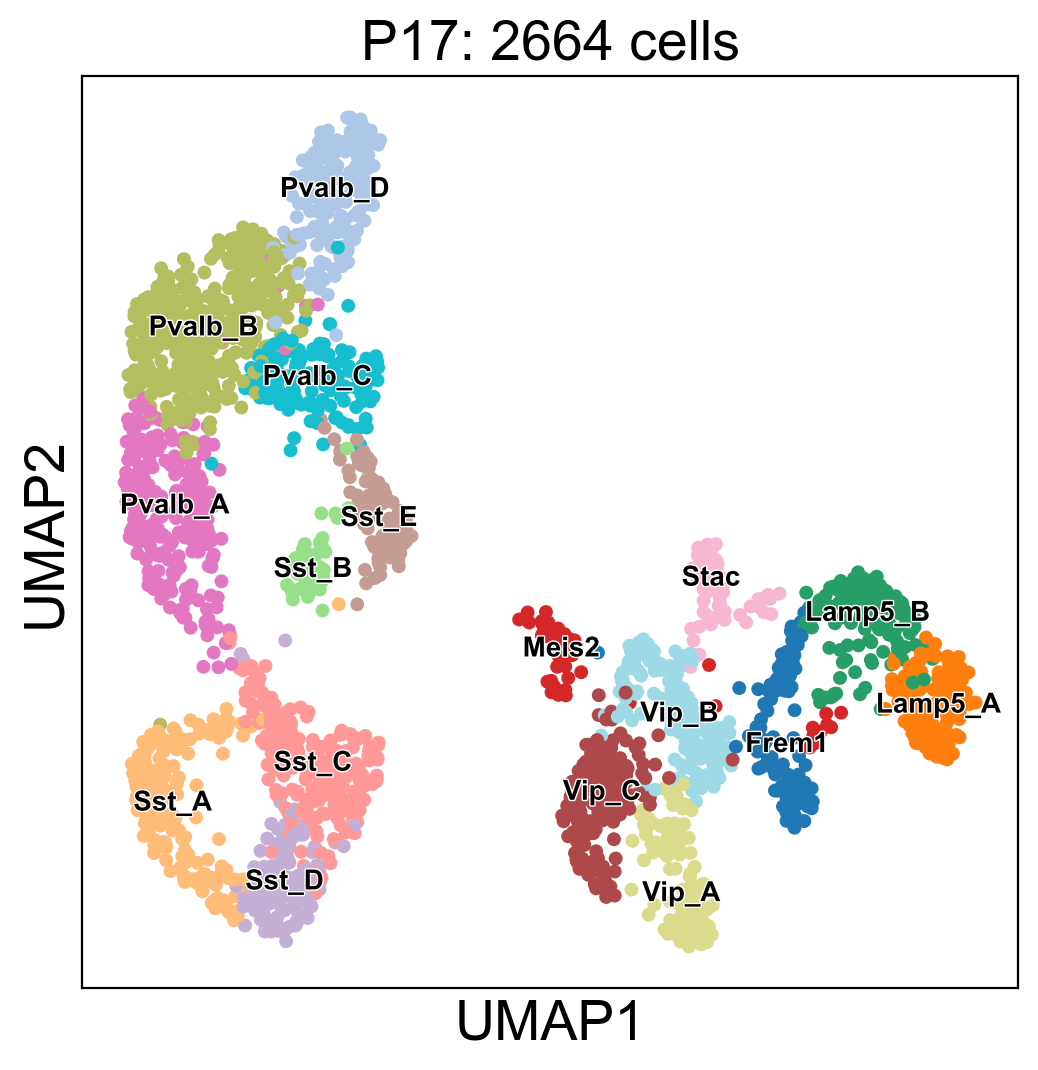

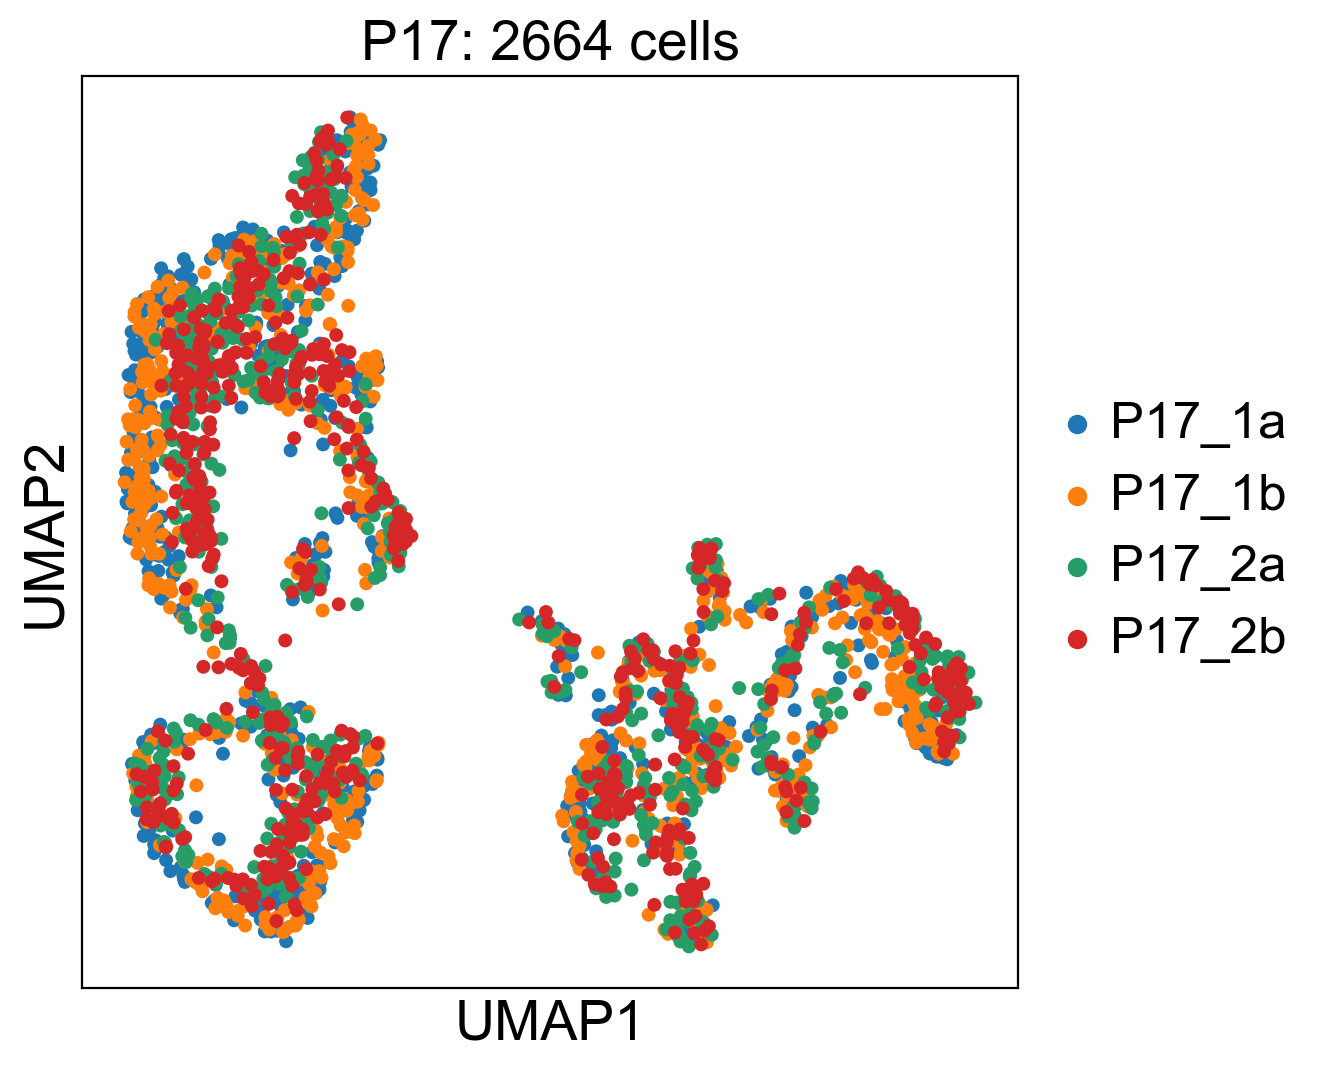

In [15]:
#sc.tl.dendrogram(P17_gaba, groupby='leiden')
umap_colors = ['#1f77b4',
 '#ff7f0e',
 '#279e68',
 '#d62728',
 '#e377c2',
 '#b5bd61',
 '#17becf',
 '#aec7e8',
 '#ffbb78',
 '#98df8a',
 '#ff9896',
 '#c5b0d5',
 '#c49c94',
 '#f7b6d2',
 '#dbdb8d',
 '#9edae5',
 '#ad494a']
sc.set_figure_params(dpi=100, figsize=(6,6), dpi_save=2000, fontsize=20)
sc.pl.umap(P17_gaba, color='cluster_name', 
           title = 'P17: ' + str(P17_gaba.shape[0]) + ' cells', frameon=True, legend_loc='on data', legend_fontoutline=1,size=100, legend_fontsize='10', palette=umap_colors)
sc.pl.umap(P17_gaba, color='sample', title = 'P17: ' + str(P17_gaba.shape[0]) + ' cells', frameon=True, size = 100)


bias_markers = ['Snap25', 'Slc17a7', 'Gad1', 'Gad2', 'Pvalb', 'Sst', 'Lamp5',
                'Vip', 'Meis2', 'Igsf9b',
                'Pax6', 'Serpinf1', 'Sncg']

bias_pos = [(0,8), (9,17)]
bias_labels = ['Neuronal', 'Non-Neuronal']
#sc.pl.dotplot(P17_gaba, bias_markers, groupby='leiden', dendrogram=True)

P17_gaba = P17_gaba[P17_gaba.obs['leiden']!='14',:]
P17_gaba = P17_gaba[P17_gaba.obs['leiden']!='17',:]

cluster_dict = {0:'Pvalb_1', 1:'Sst_1', 2:'Pvalb_2', 3:'Pvalb_3', 4:'Sst_3', 5:'Vip_2', 6:'Vip_3', 7:'Lamp5_2', 
                8:'Pvalb_4', 9:'Lamp5_3', 10:'Vip_1', 11:'Ambig_1', 12:'Sst_2', 13:'Ambig_2', 15:'Sst_4', 16:'Lamp5_1'}

cluster = []
for i in cluster_dict: cluster.append((cluster_dict[i]))

P17_gaba.obs['cluster'] = P17_gaba.obs['leiden']
P17_gaba.rename_categories(key='cluster', categories=cluster)

### Finalize type names P17

In [219]:
P17_gaba.obs['cluster_name'] = P17_gaba.obs['cluster']
P17_gaba.obs['cluster_name'] = pd.Series(cluster_namesP17, dtype="category").values #41 in 'remove'

In [221]:
P17_gaba = P17_gaba[P17_gaba.obs['cluster_name']!='remove',:]

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns["dendrogram_['cluster_name']"]`


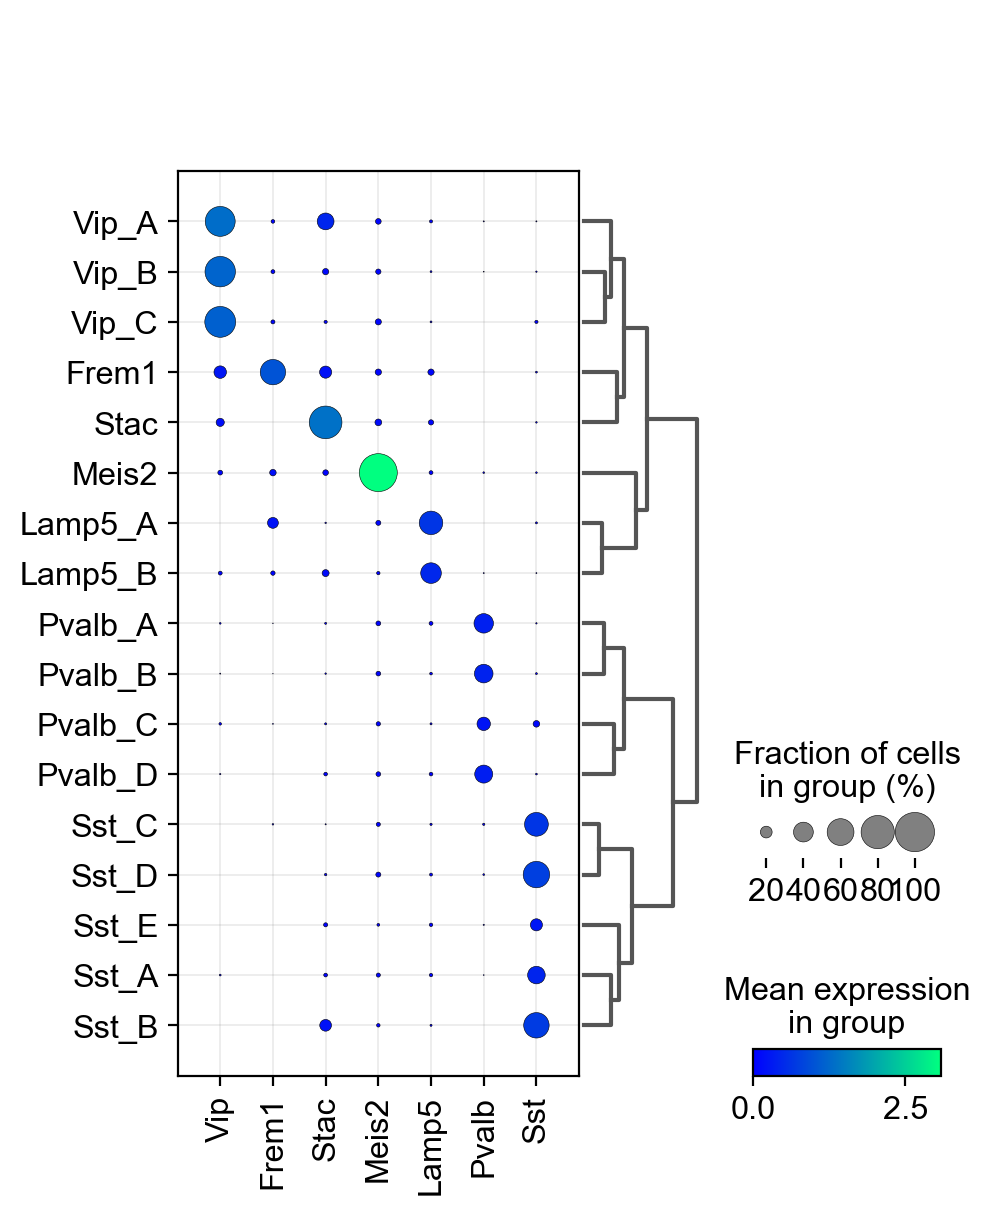

/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


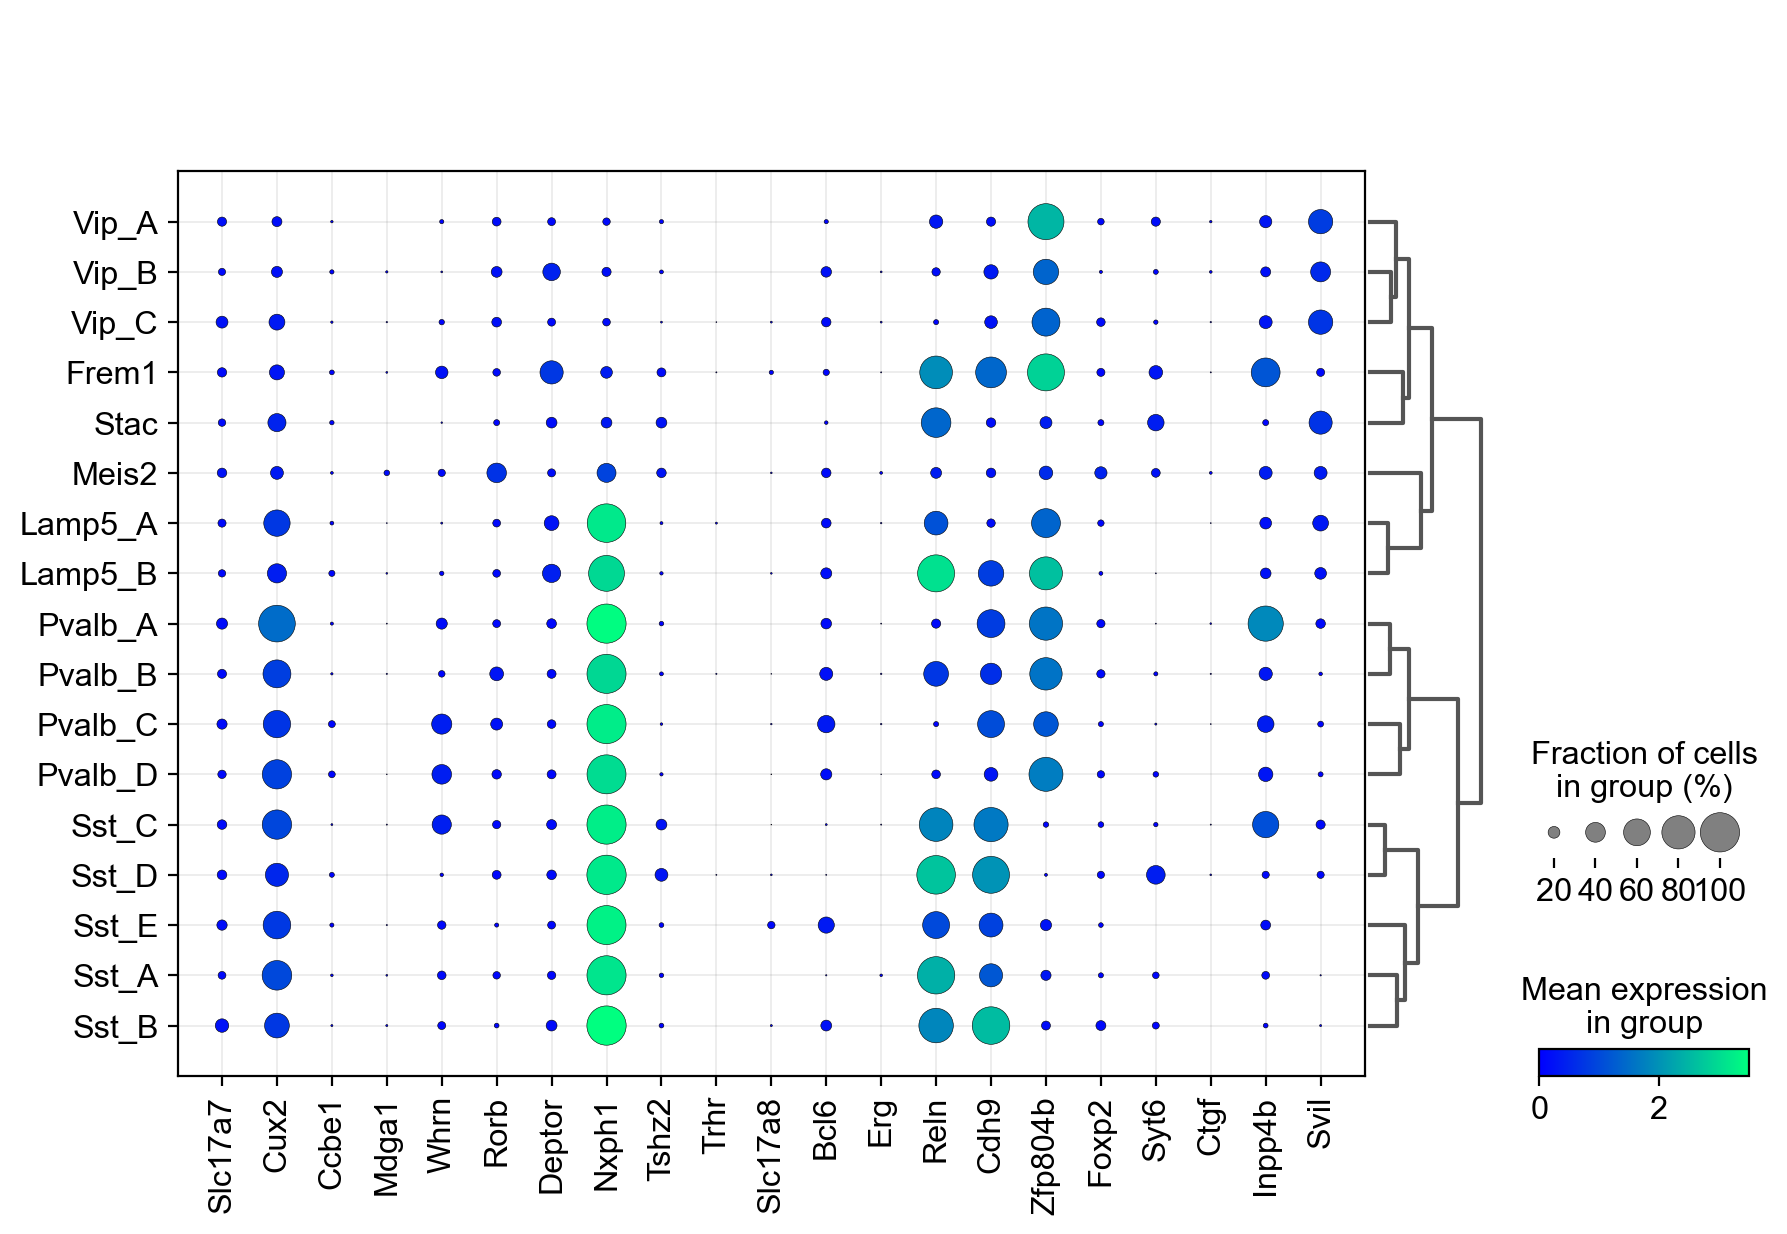

In [12]:
bias_markers = ['Vip', 'Frem1',
                'Stac', 'Meis2',
                'Lamp5',
               'Pvalb', 'Sst']

layer_markers = ['Slc17a7',
    'Cux2', 'Ccbe1', 'Mdga1', 
              'Whrn', 'Rorb',
              'Deptor', 
              'Nxph1', 'Tshz2', 'Trhr', 'Slc17a8', 
              'Bcl6', 'Erg', 'Reln', 
              'Cdh9', 'Zfp804b',
              'Foxp2', 'Syt6',
              'Ctgf', 'Inpp4b', 'Svil']

bias_pos = [(0,8), (9,17)]
bias_labels = ['Neuronal', 'Non-Neuronal']
sc.pl.dotplot(P17_gaba, bias_markers, groupby='cluster_name', dendrogram=True, return_fig=True).style(cmap='winter', grid=True).show()
sc.pl.dotplot(P17_gaba, layer_markers, groupby='cluster_name', dendrogram=True,  return_fig=True).style(cmap='winter', grid=True).show()

ranking genes


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


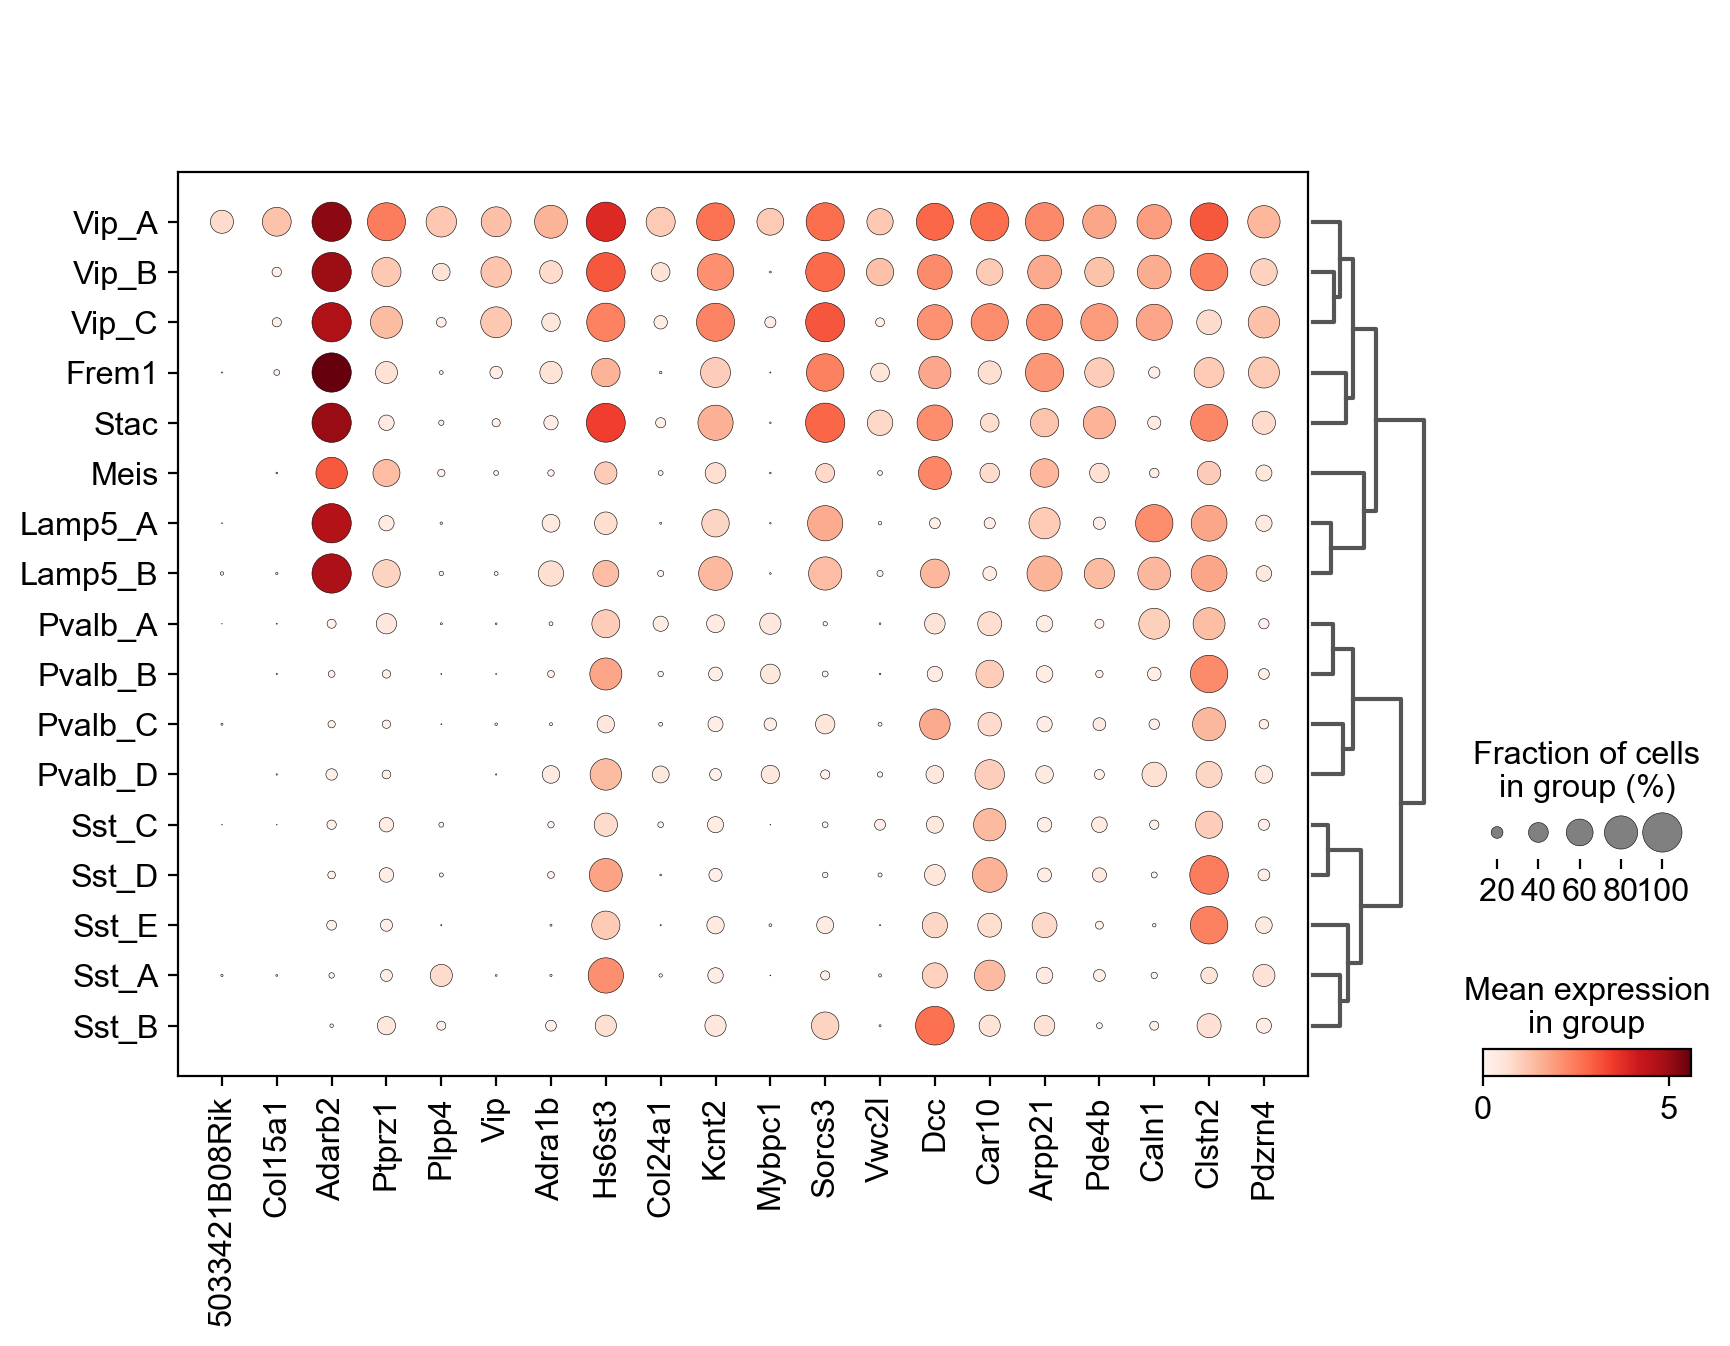

ranking genes


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


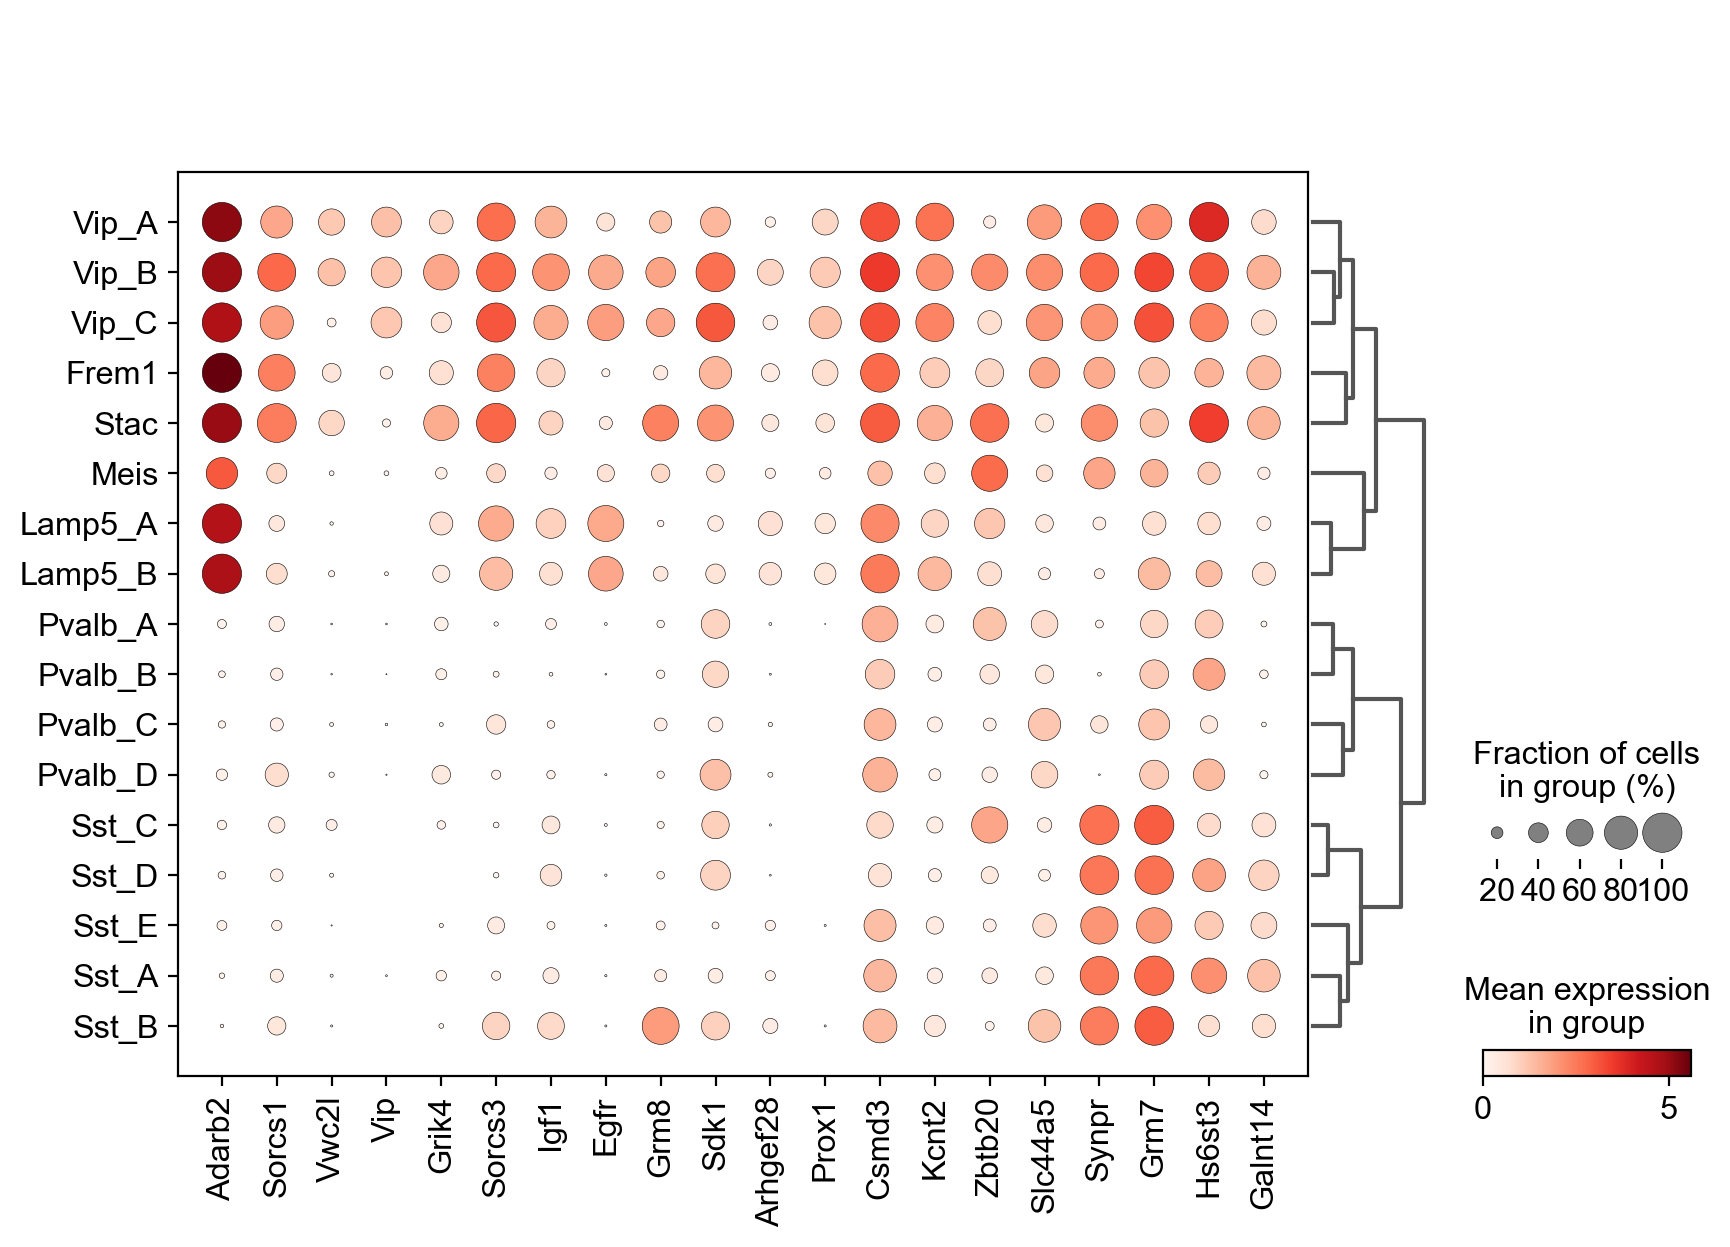

ranking genes


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


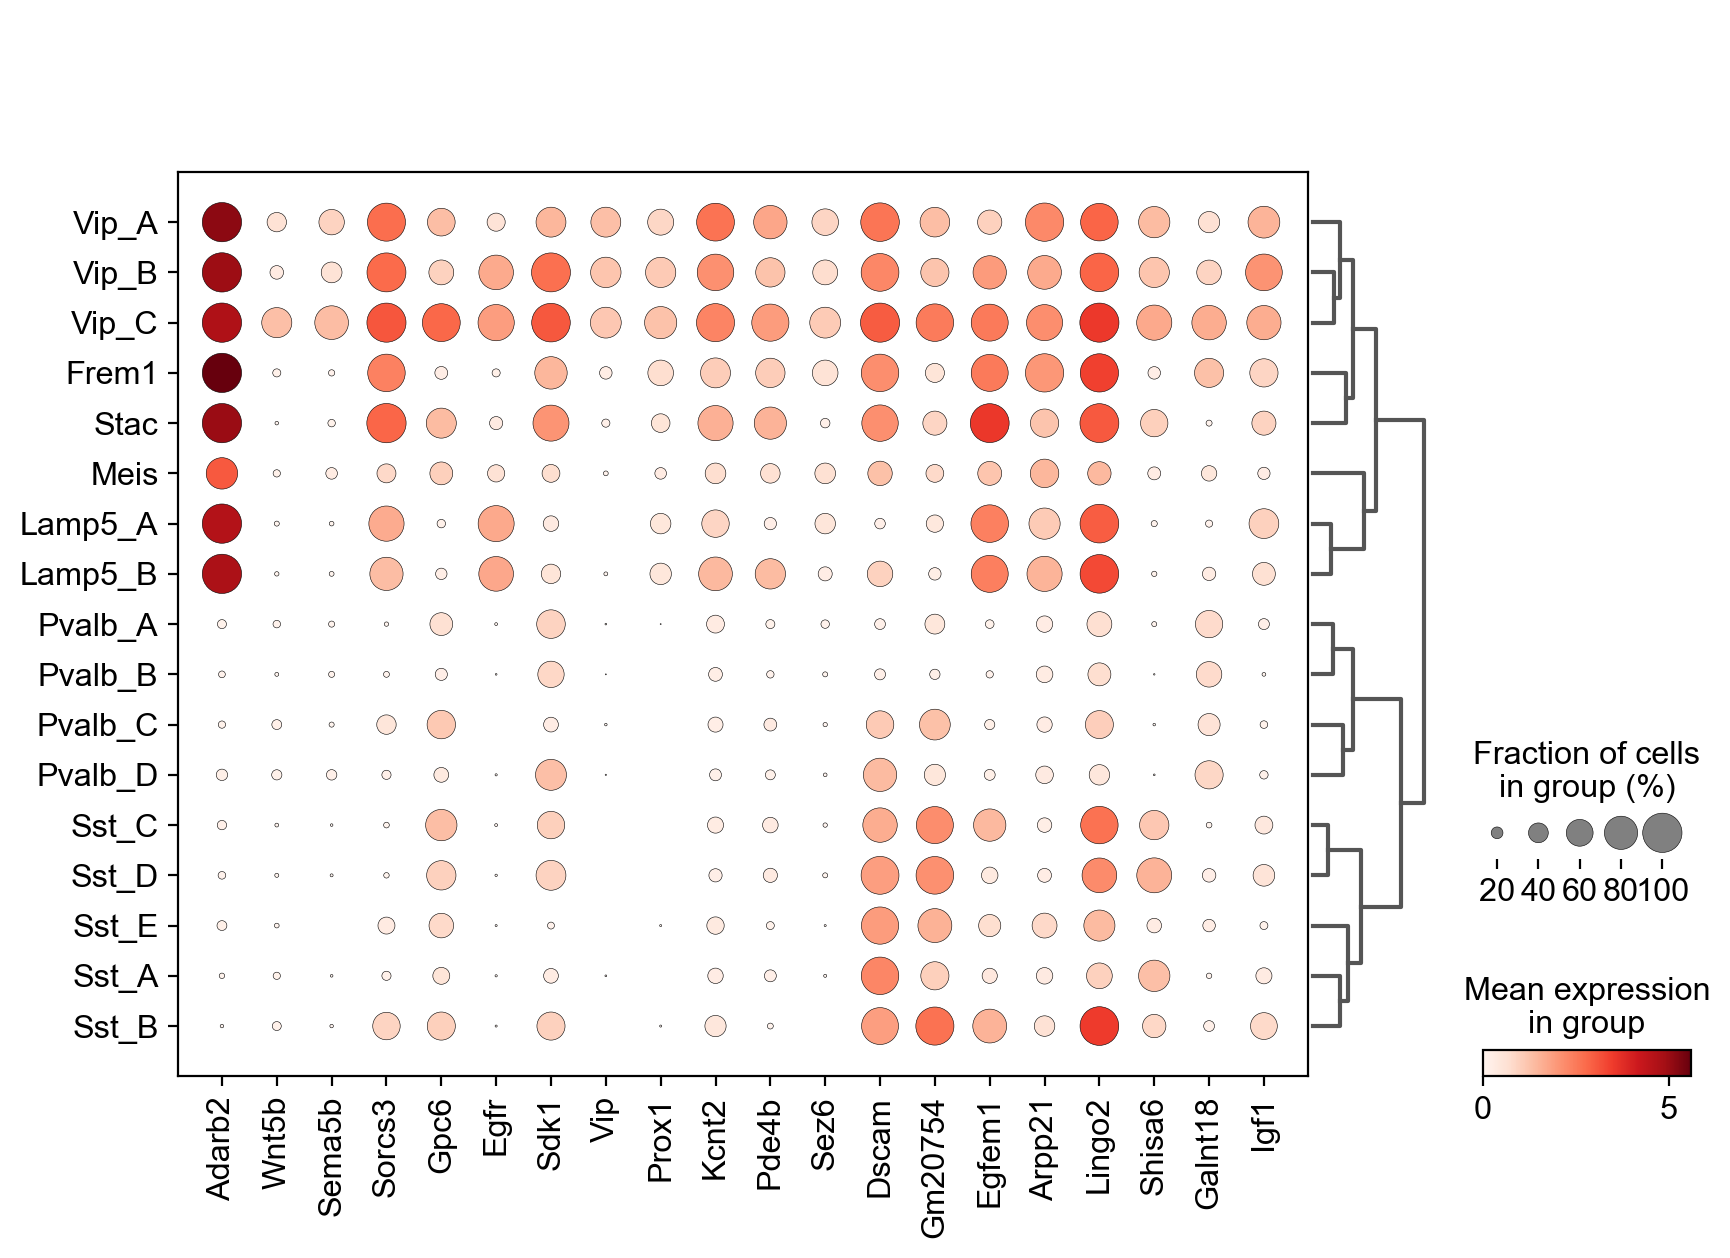

ranking genes


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


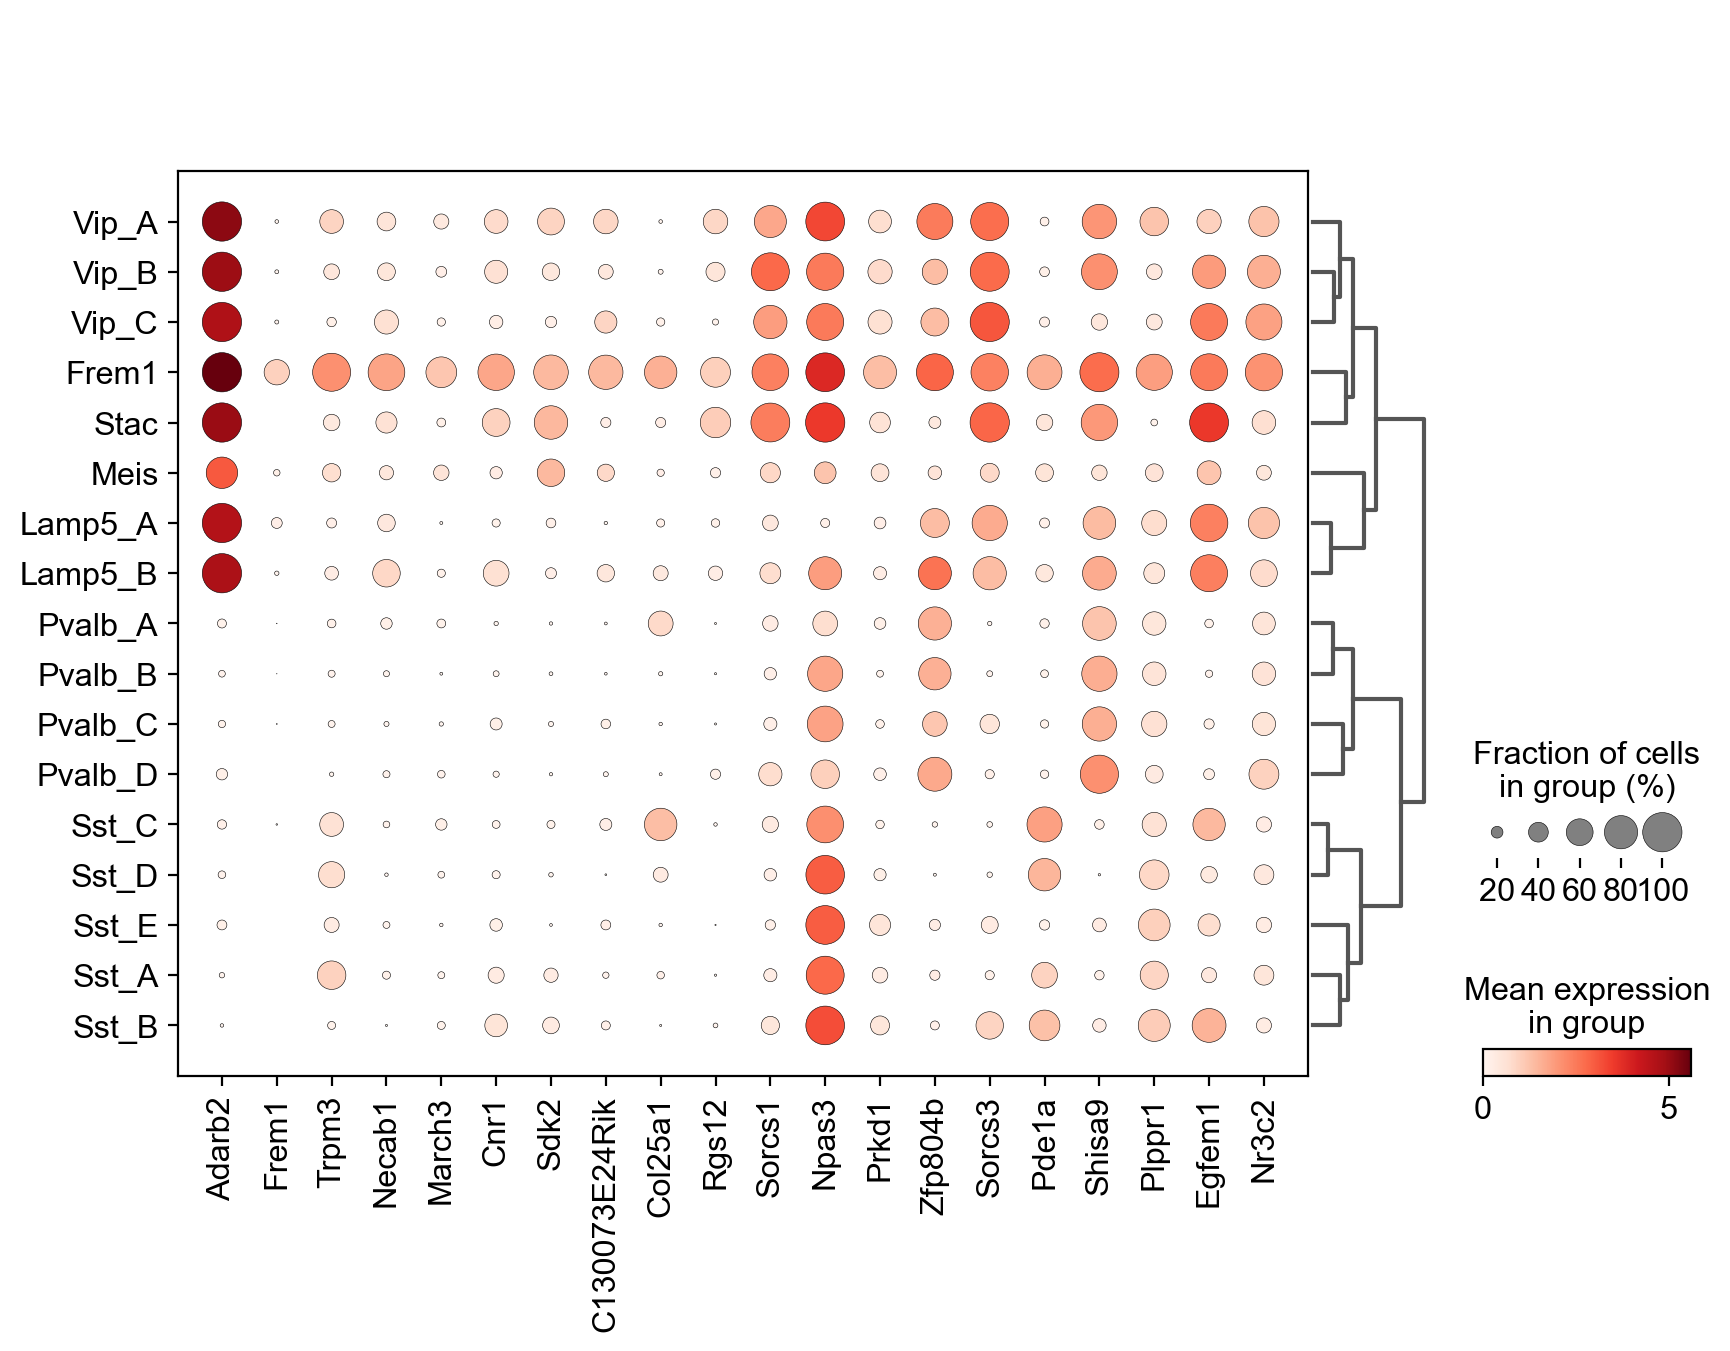

ranking genes


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


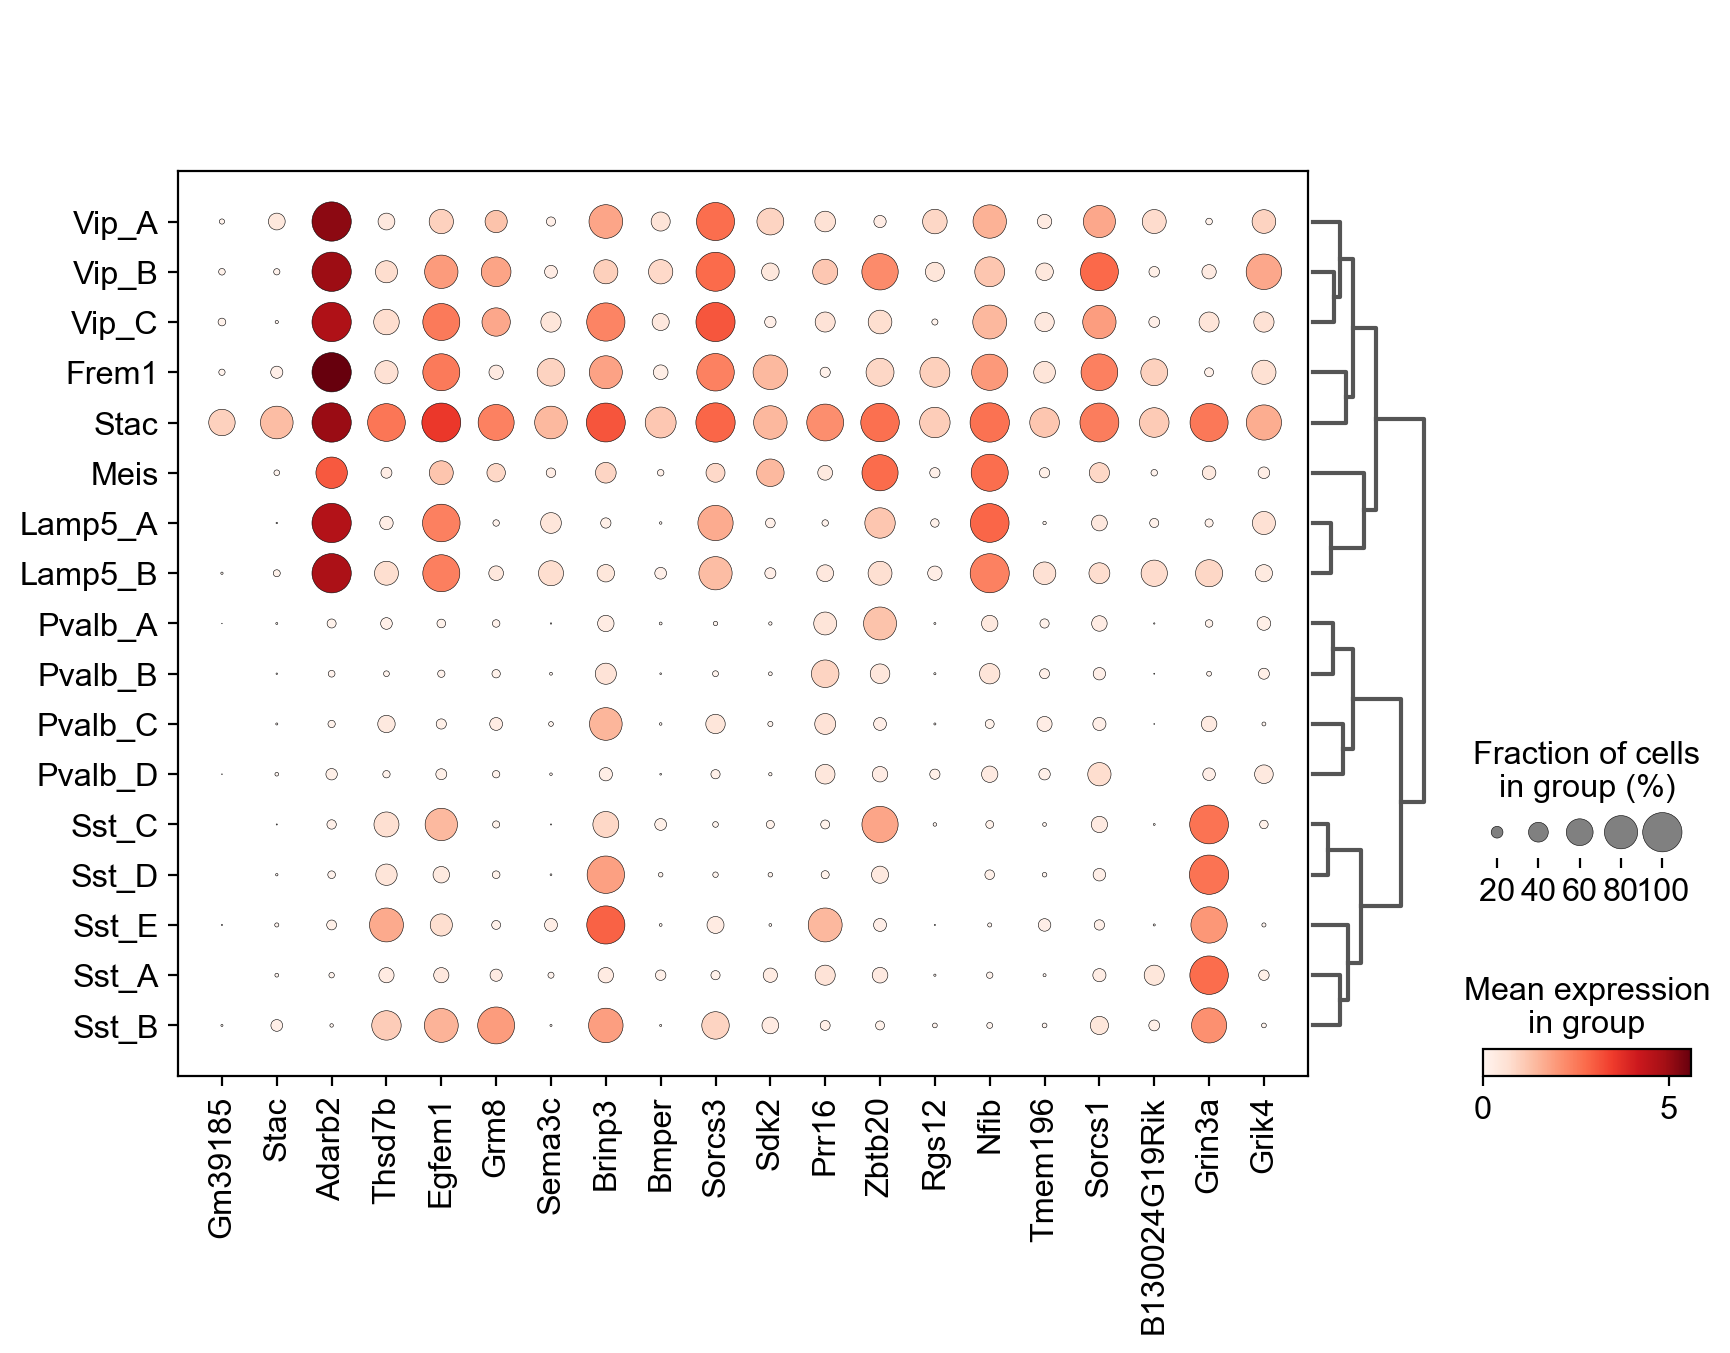

ranking genes


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


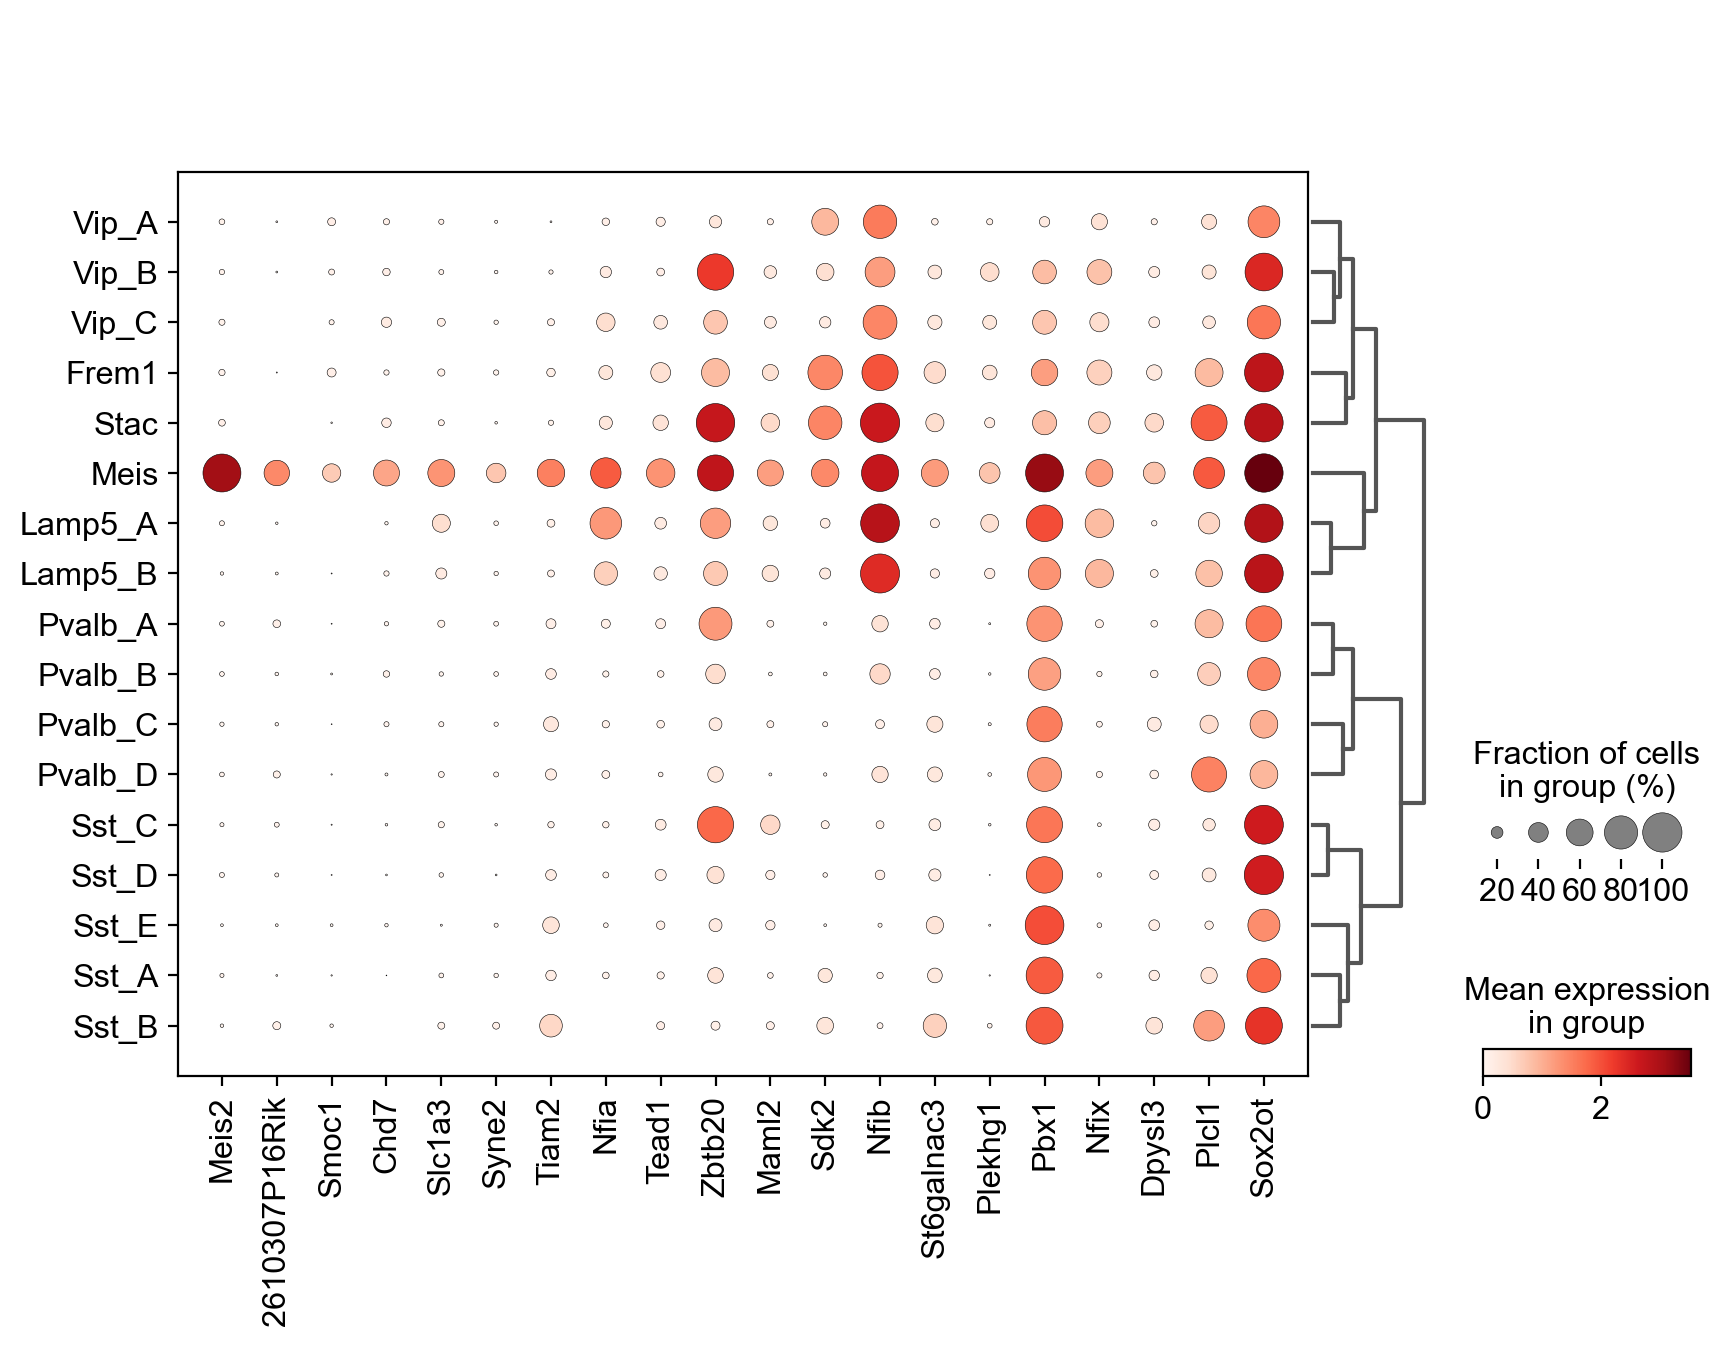

ranking genes


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


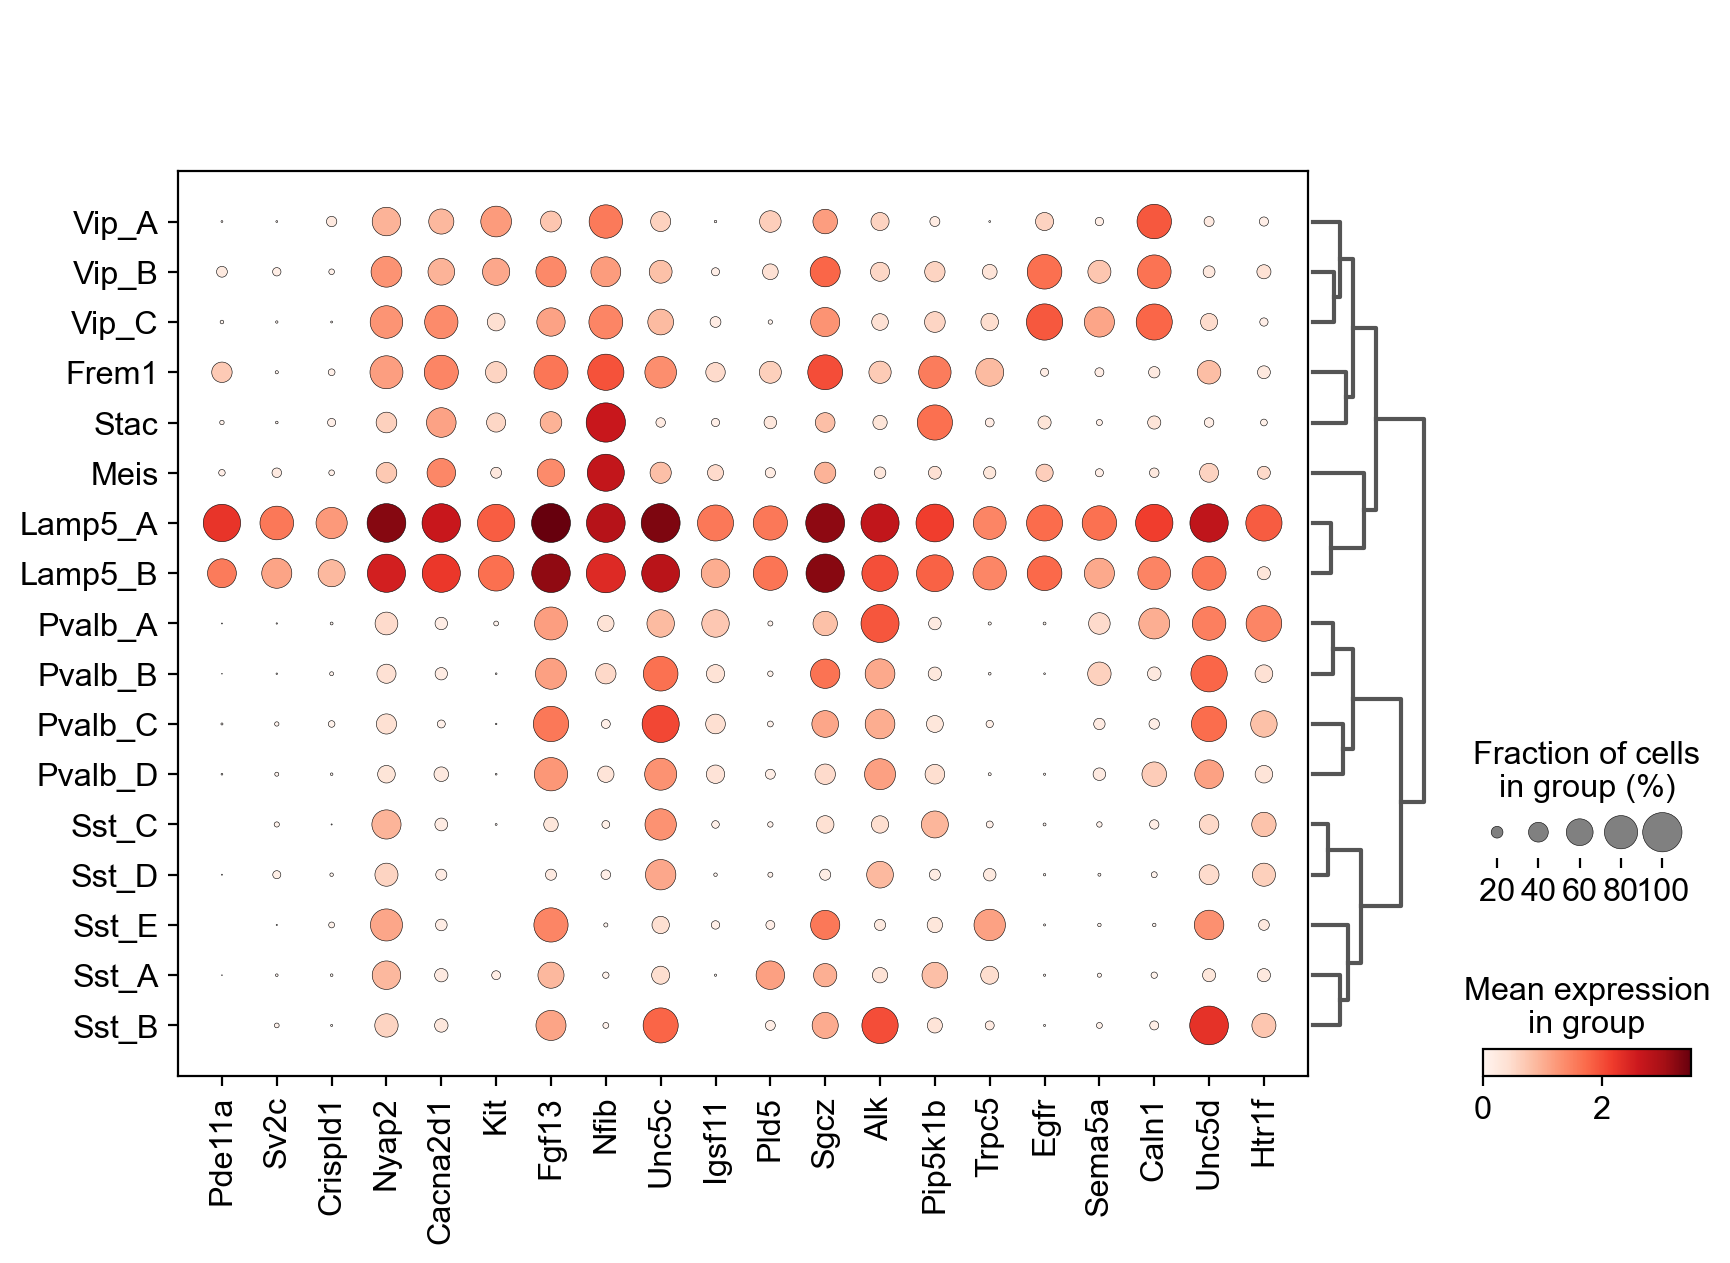

ranking genes


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


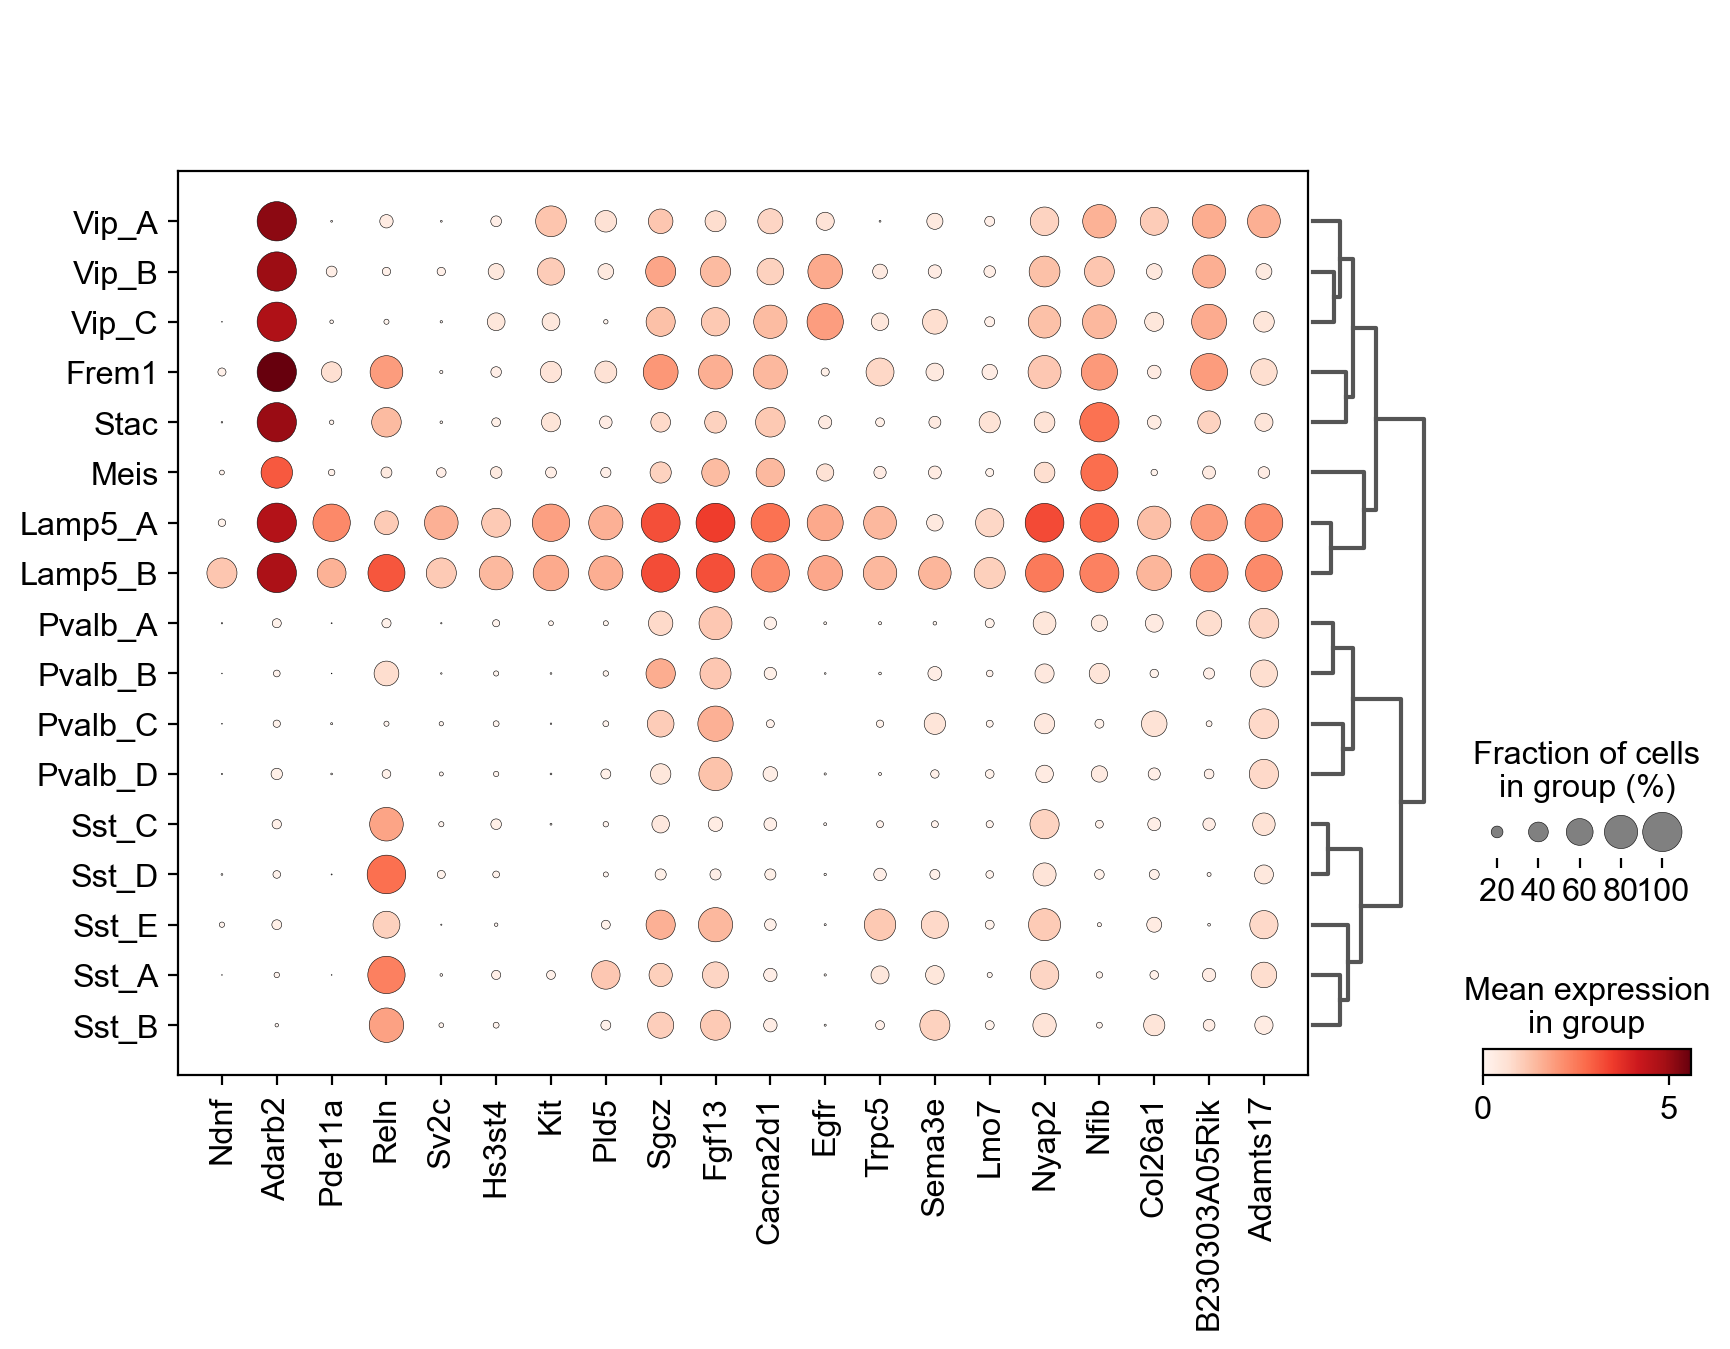

ranking genes


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


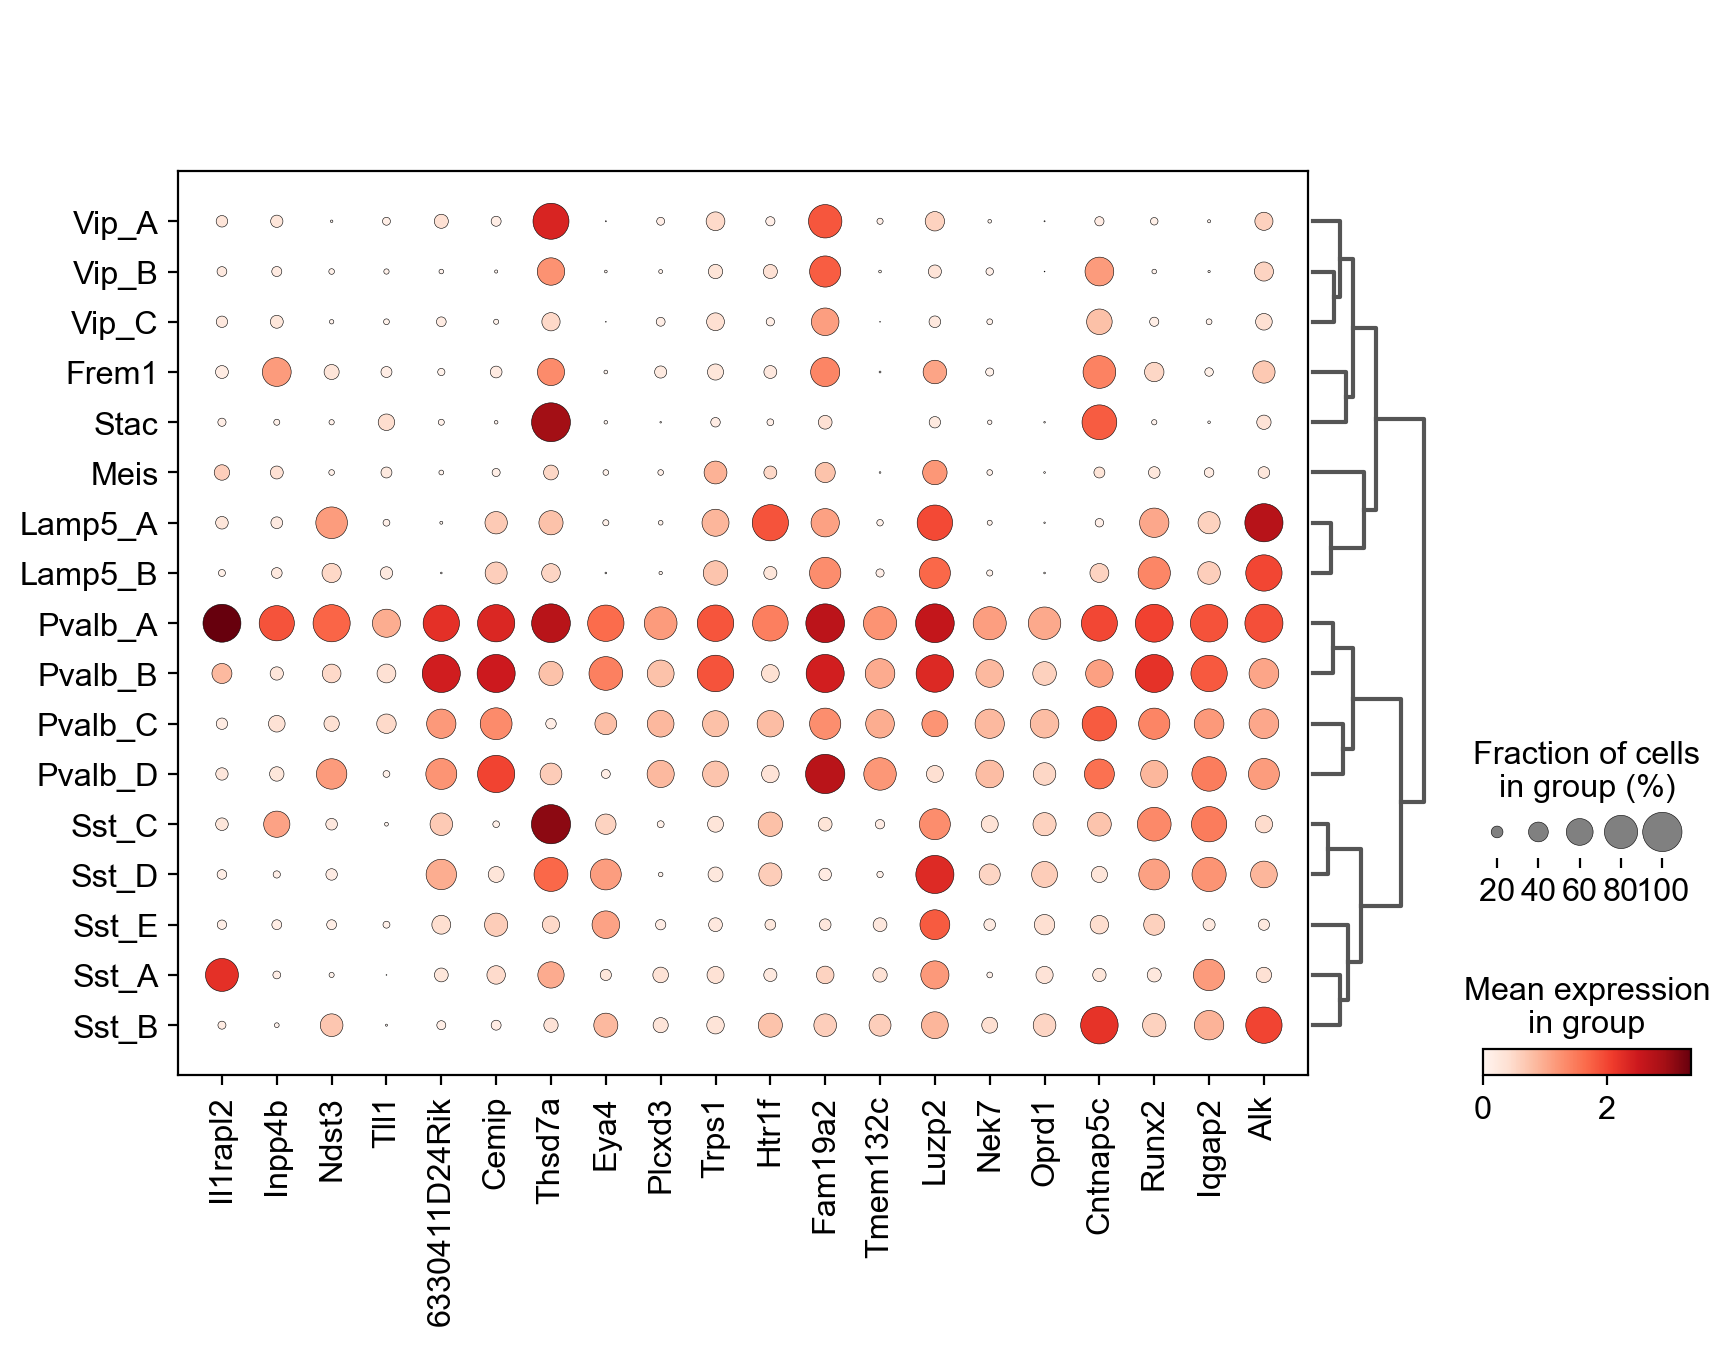

ranking genes


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


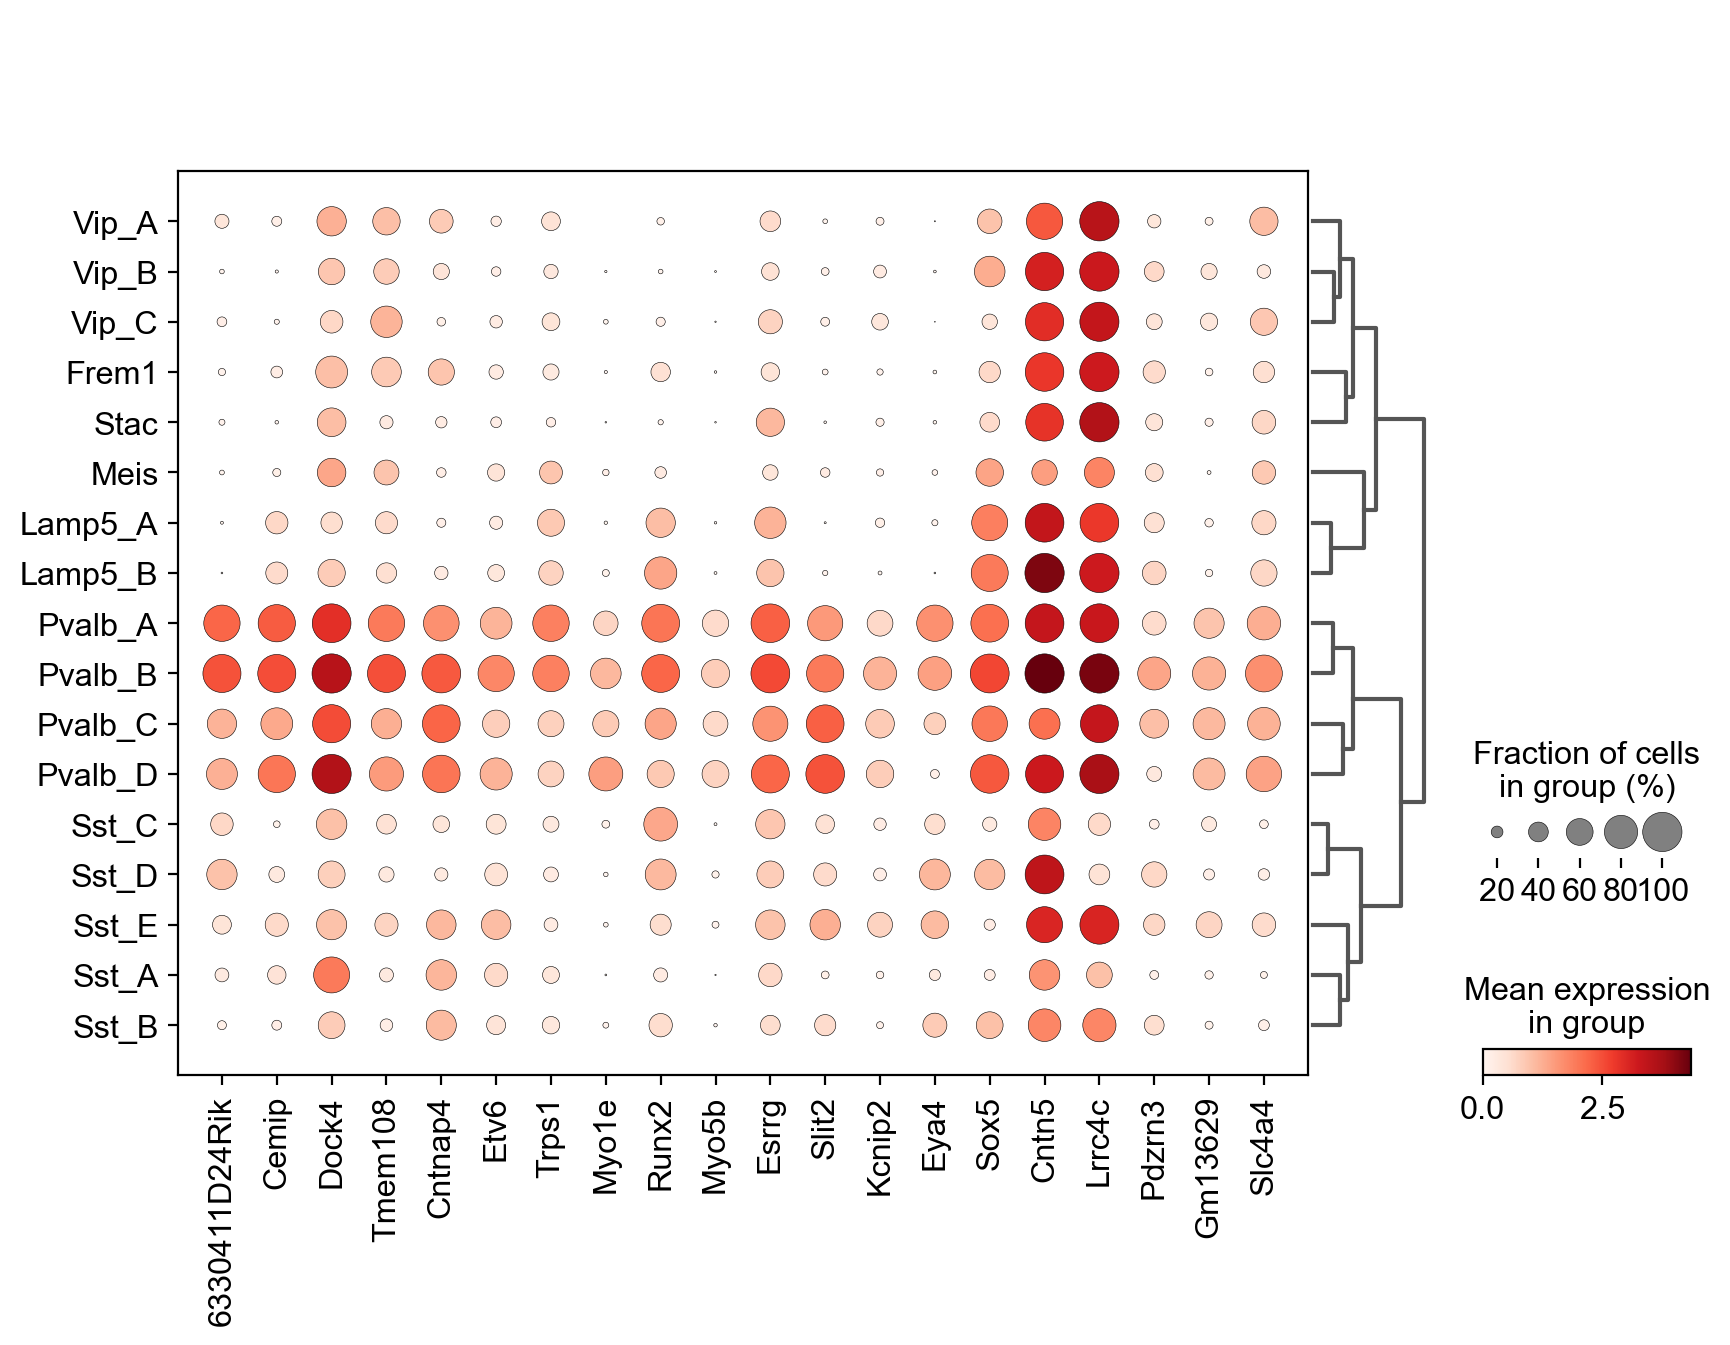

ranking genes


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


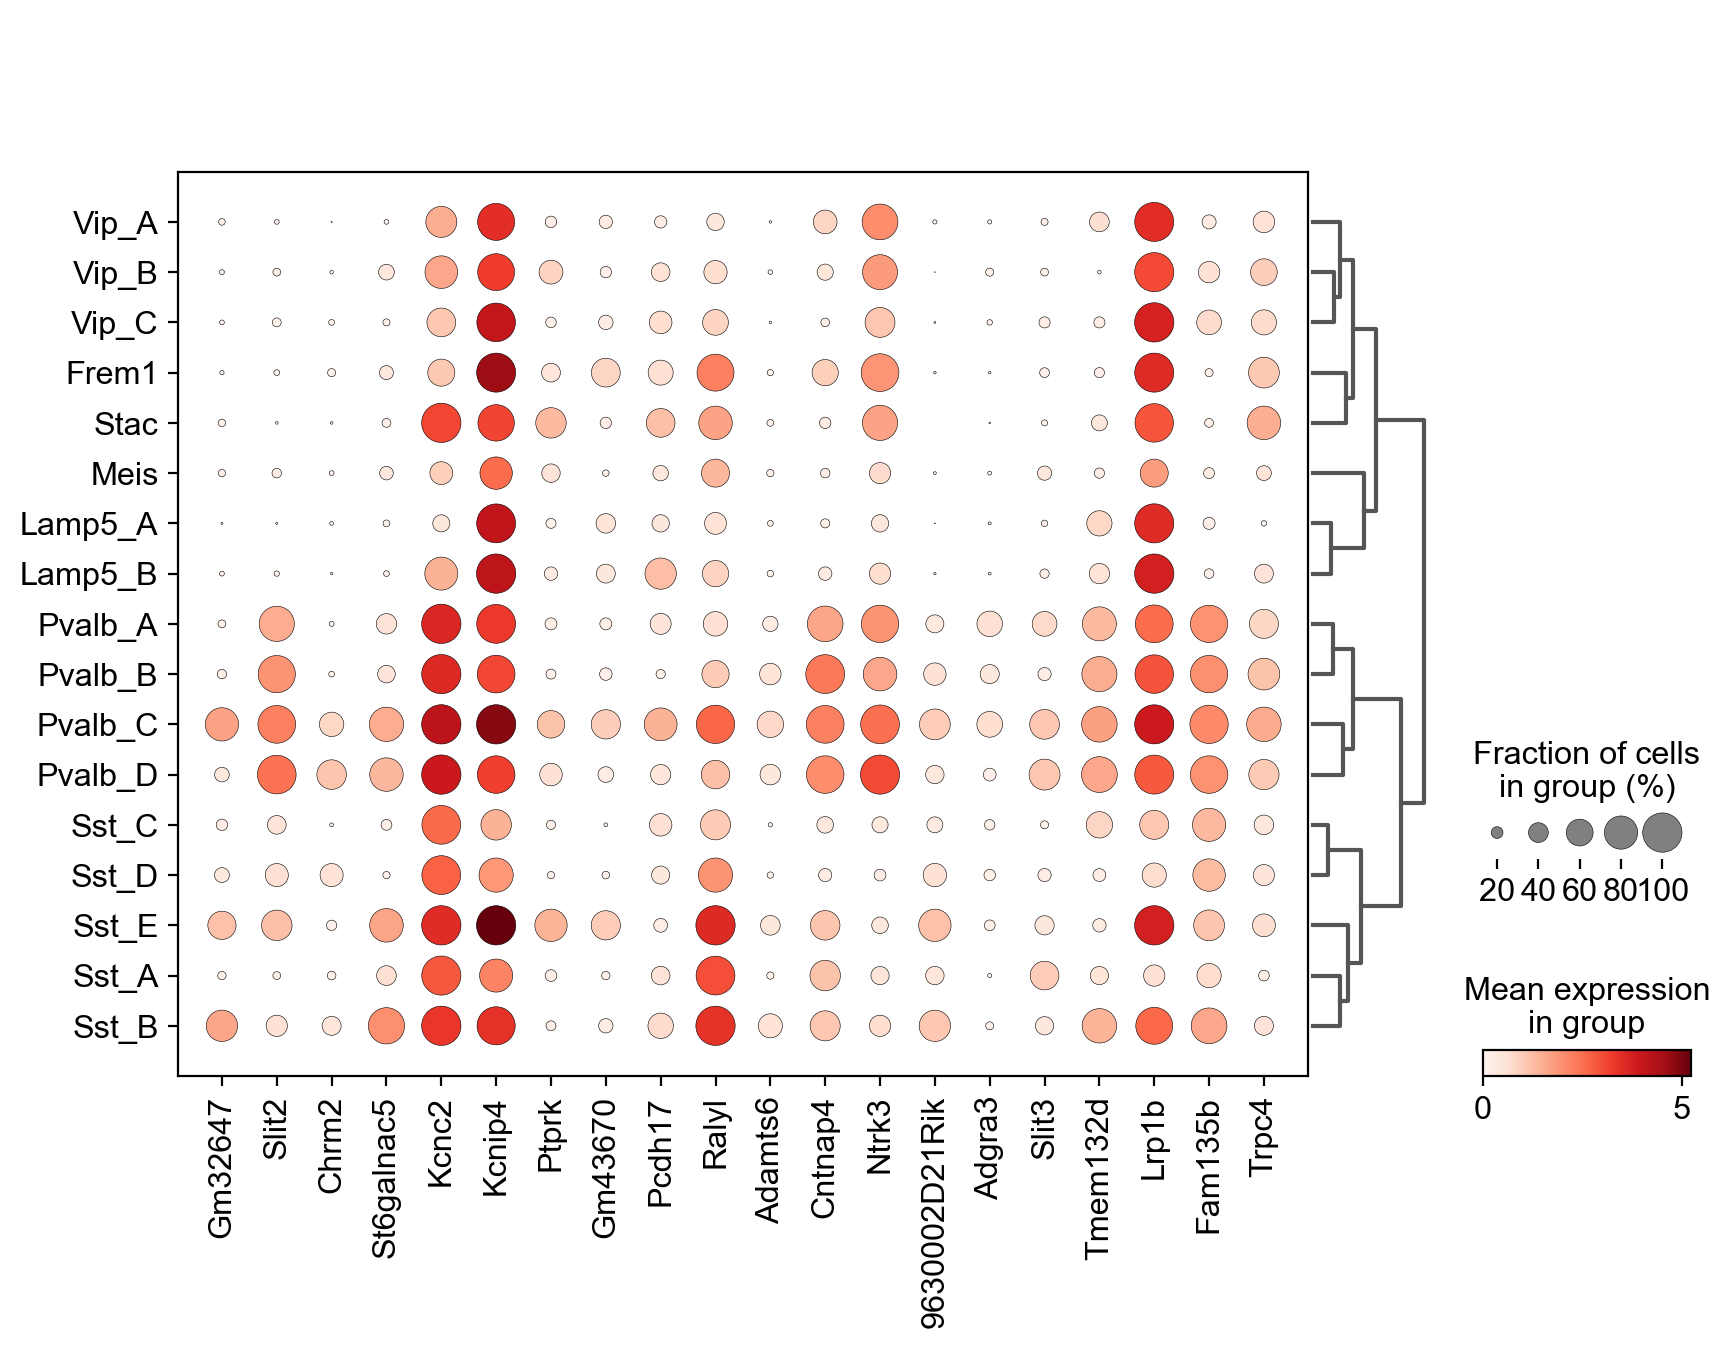

ranking genes


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)


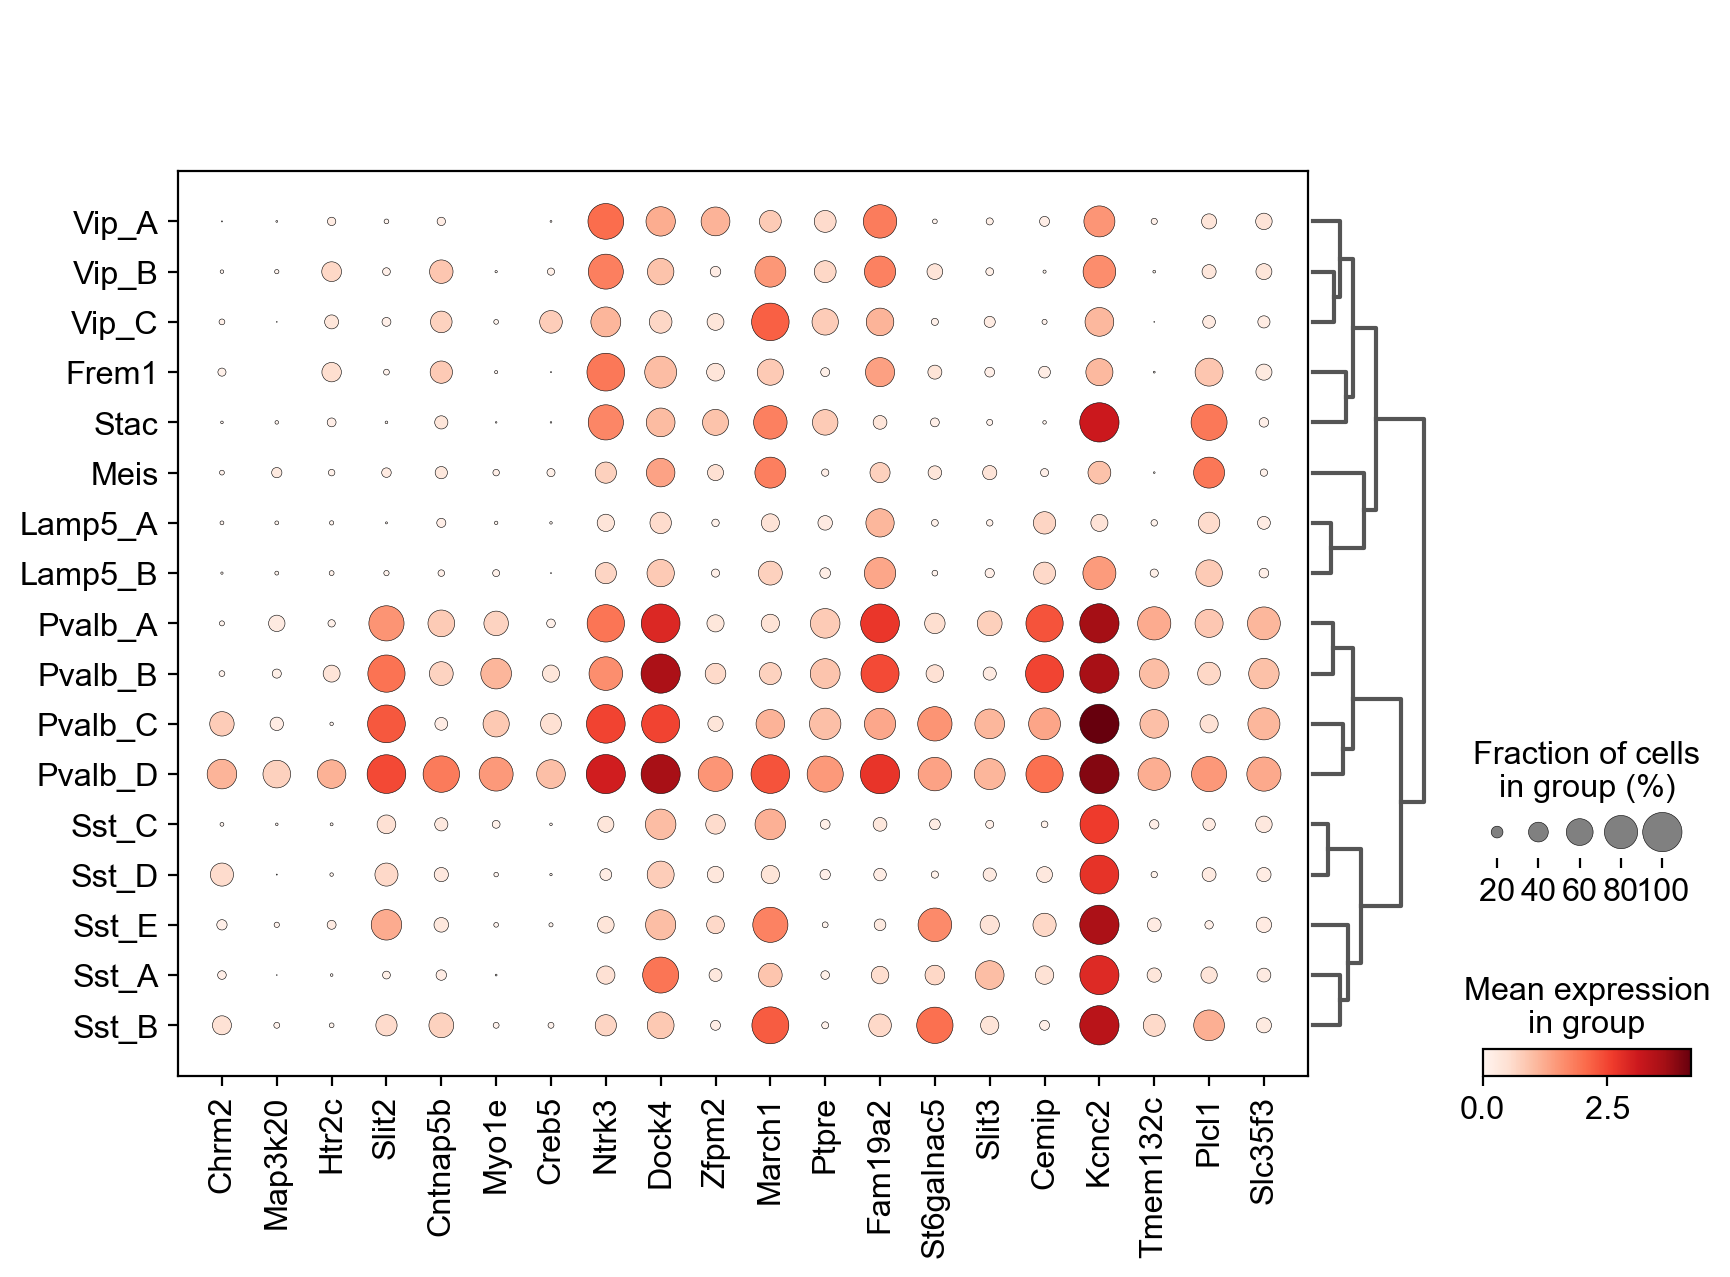

ranking genes


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


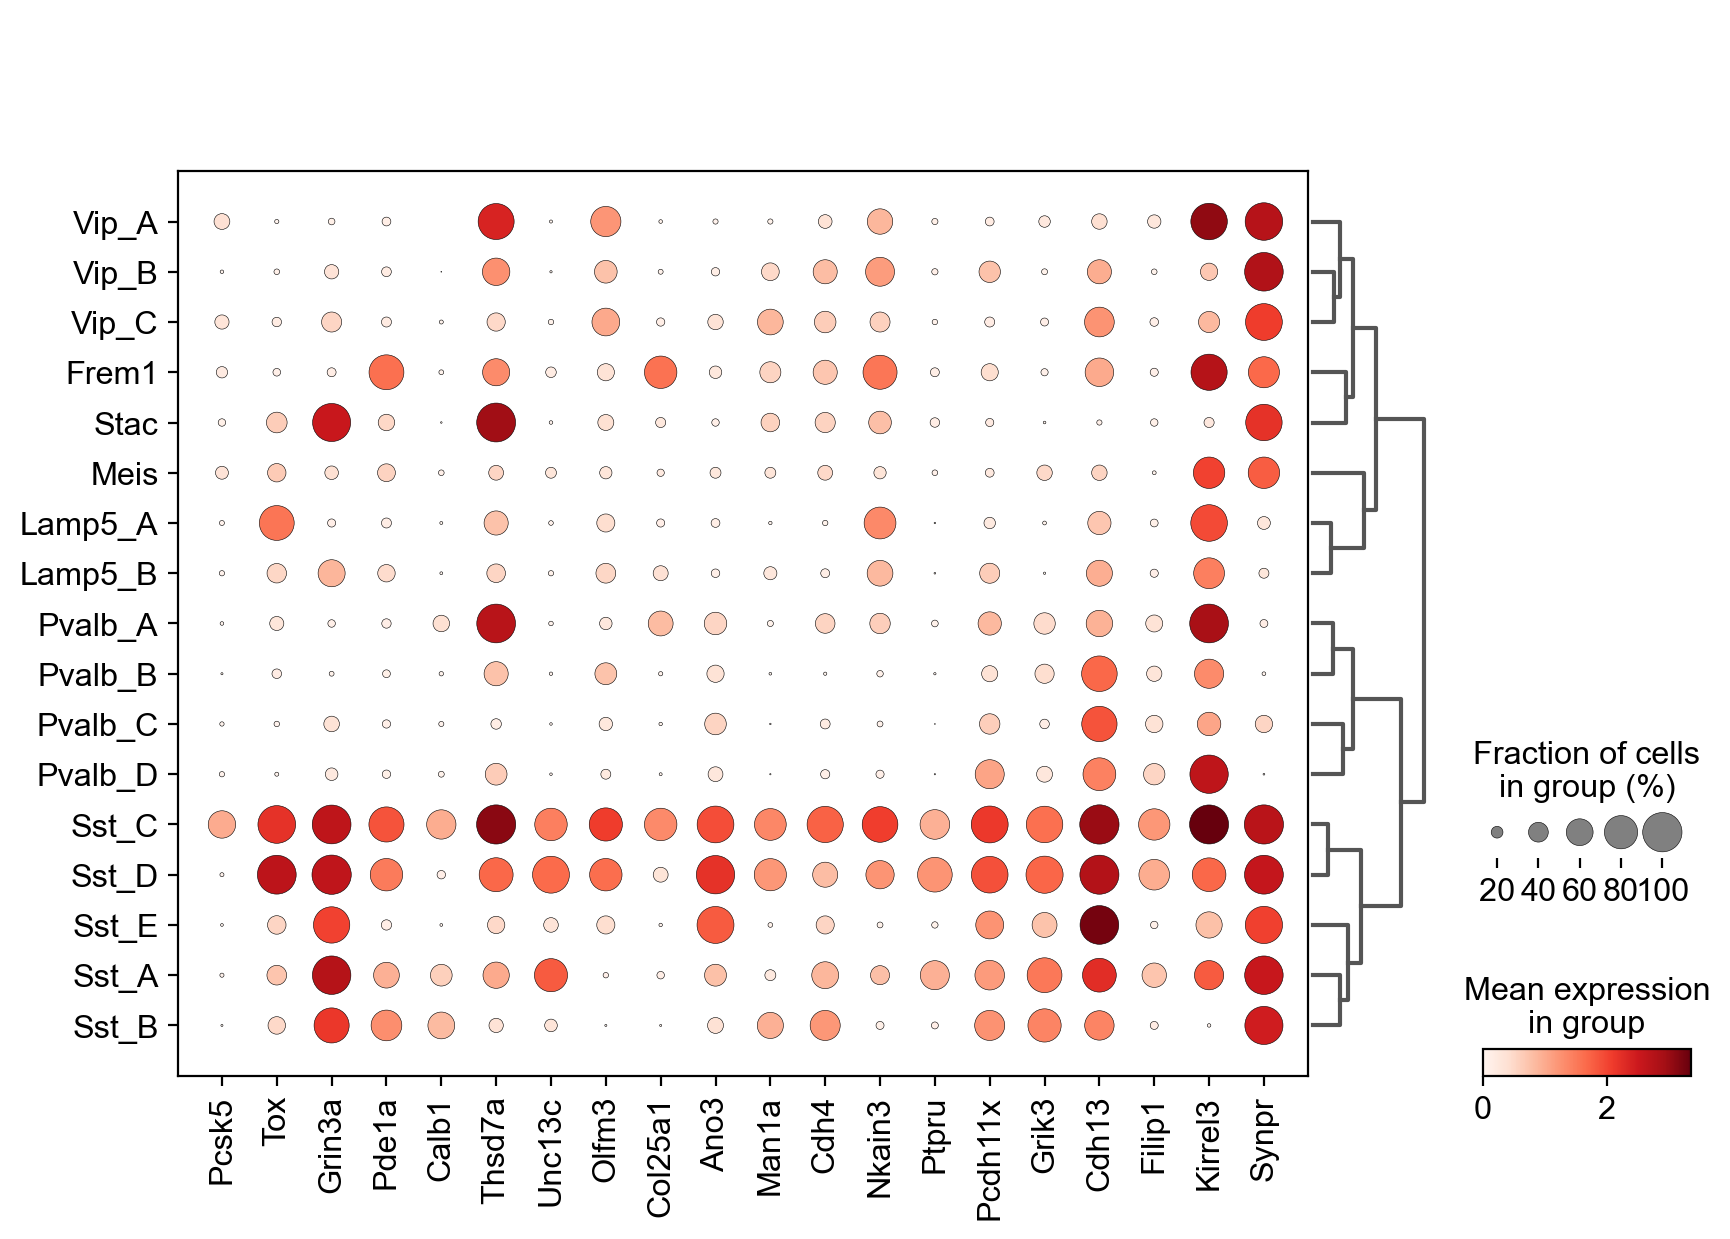

ranking genes


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


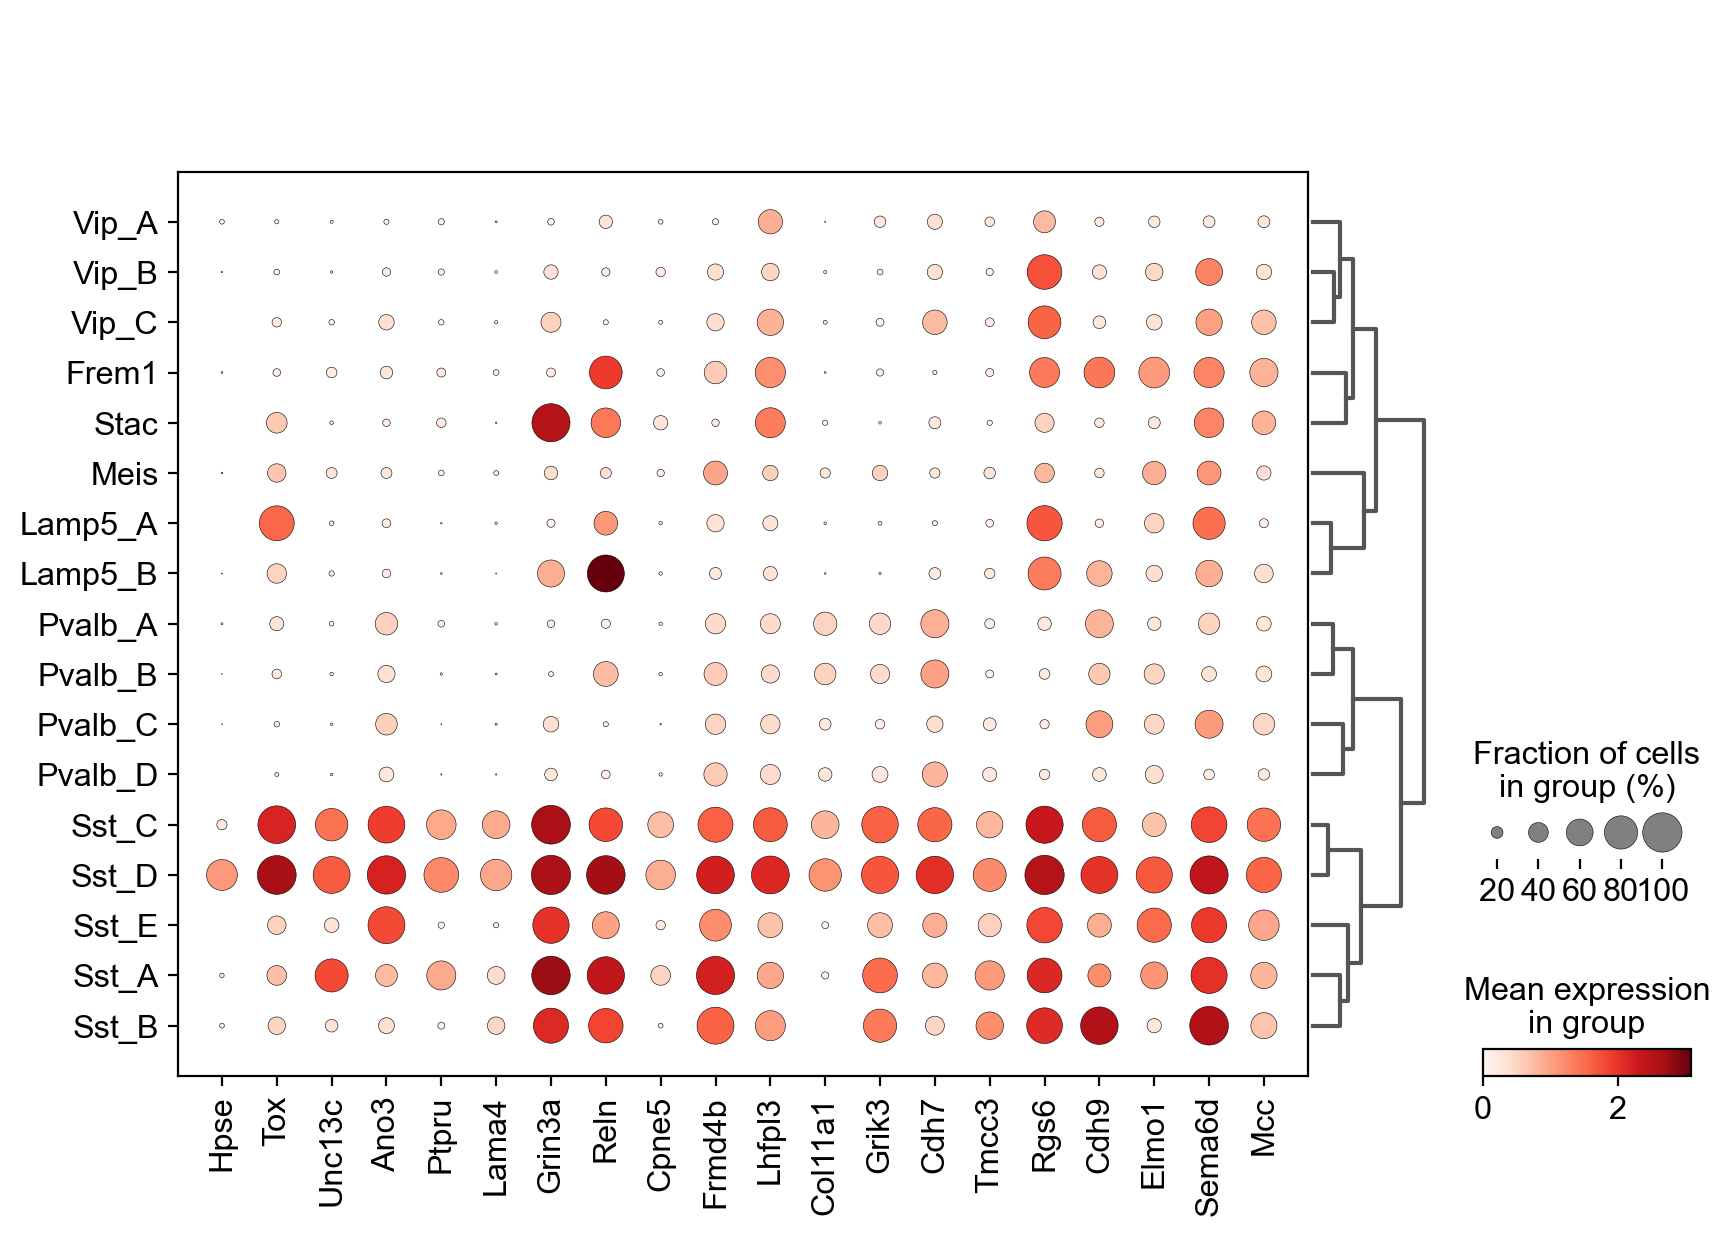

ranking genes


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


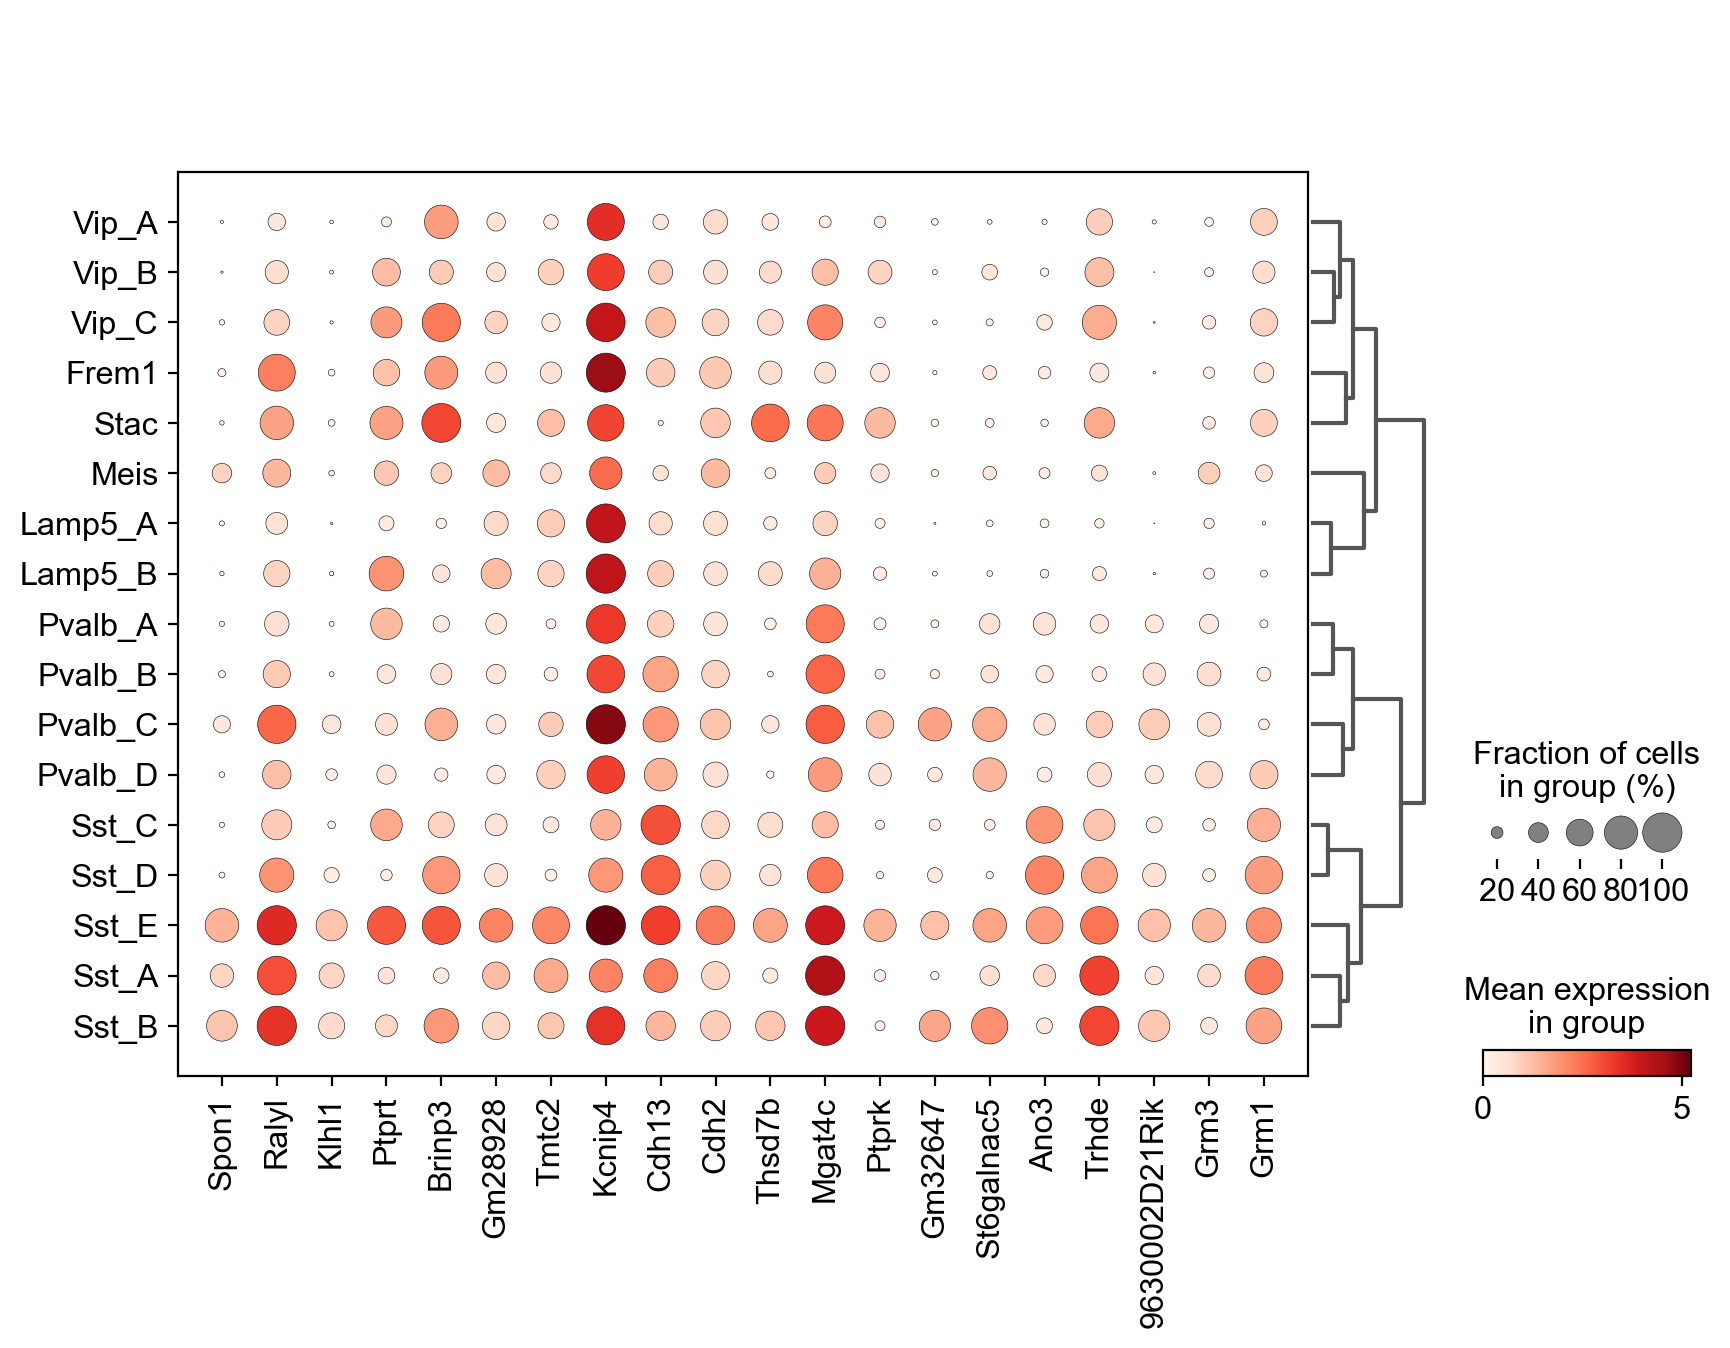

ranking genes


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


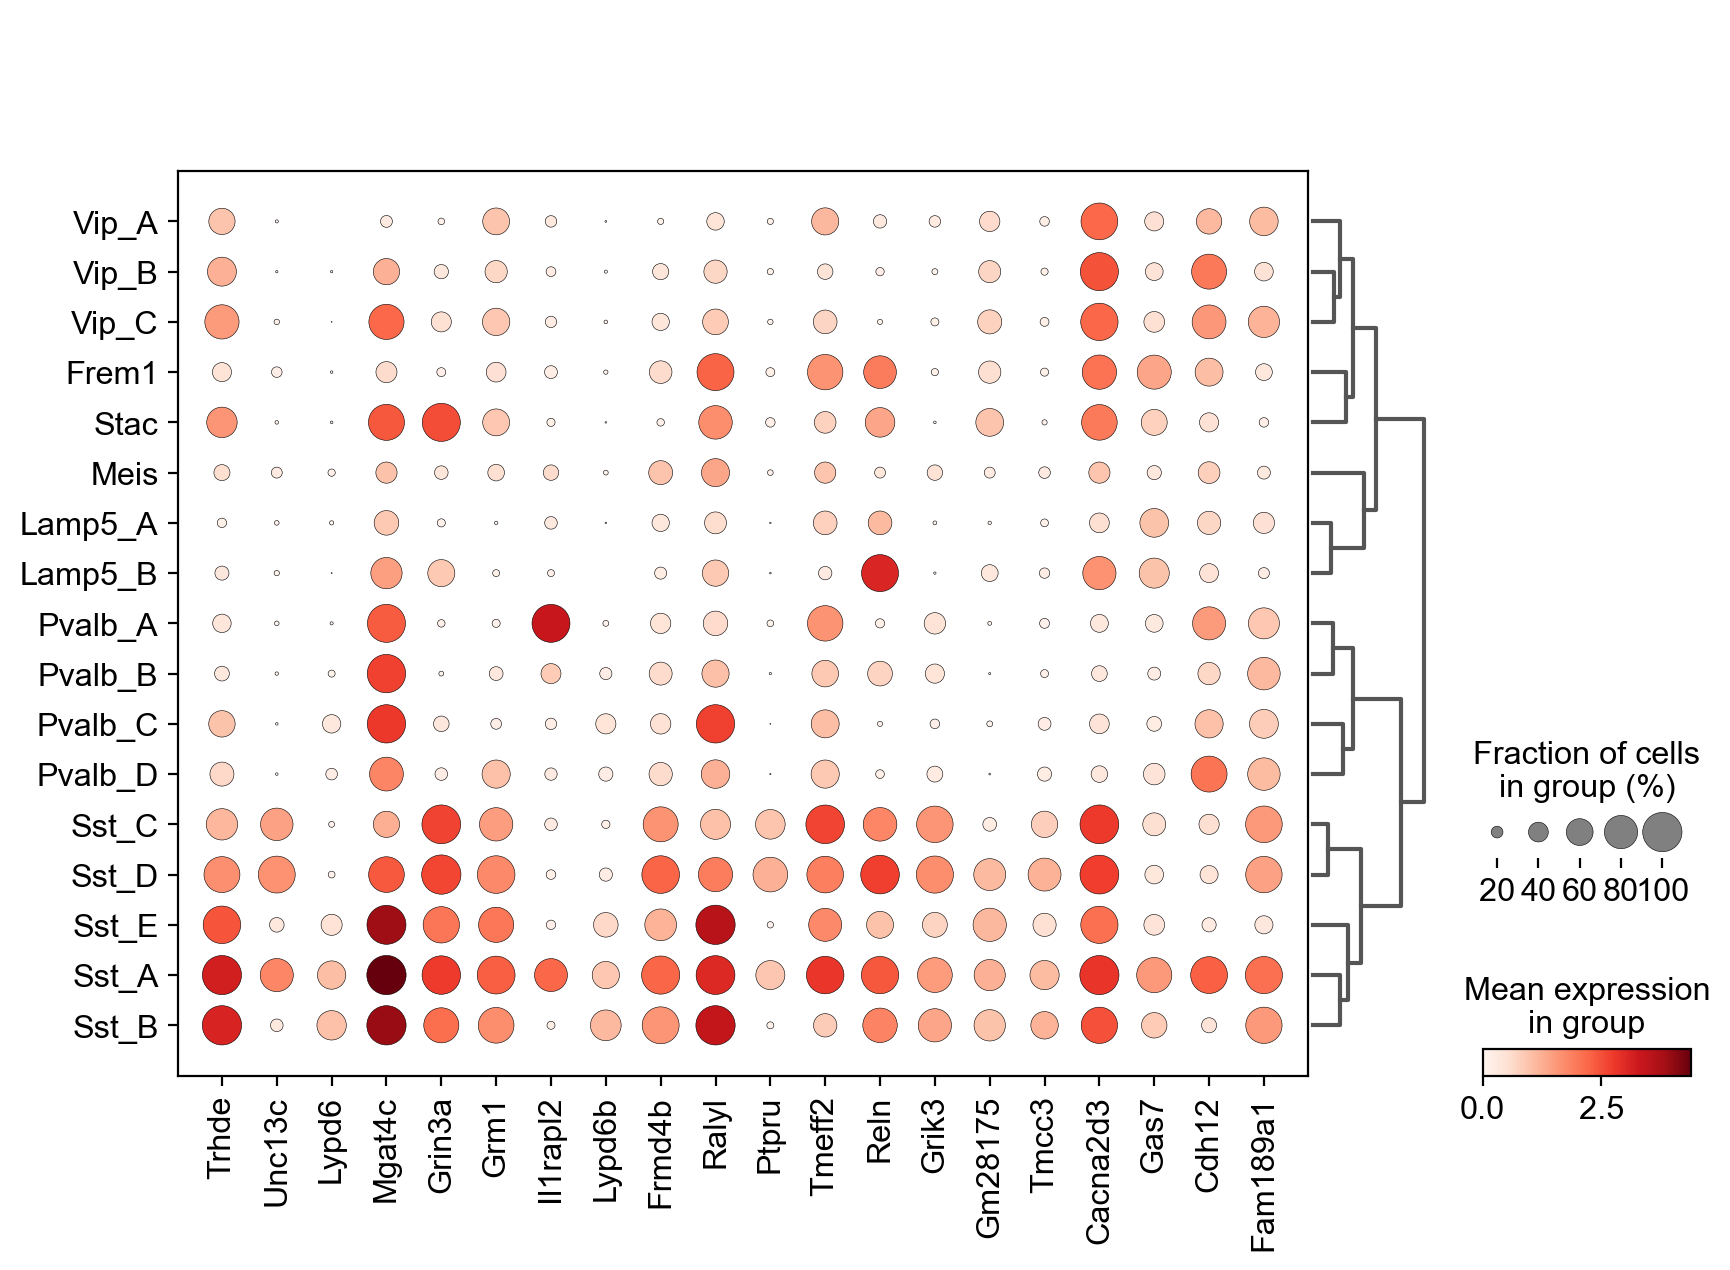

ranking genes


/Users/salwanbutrus/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


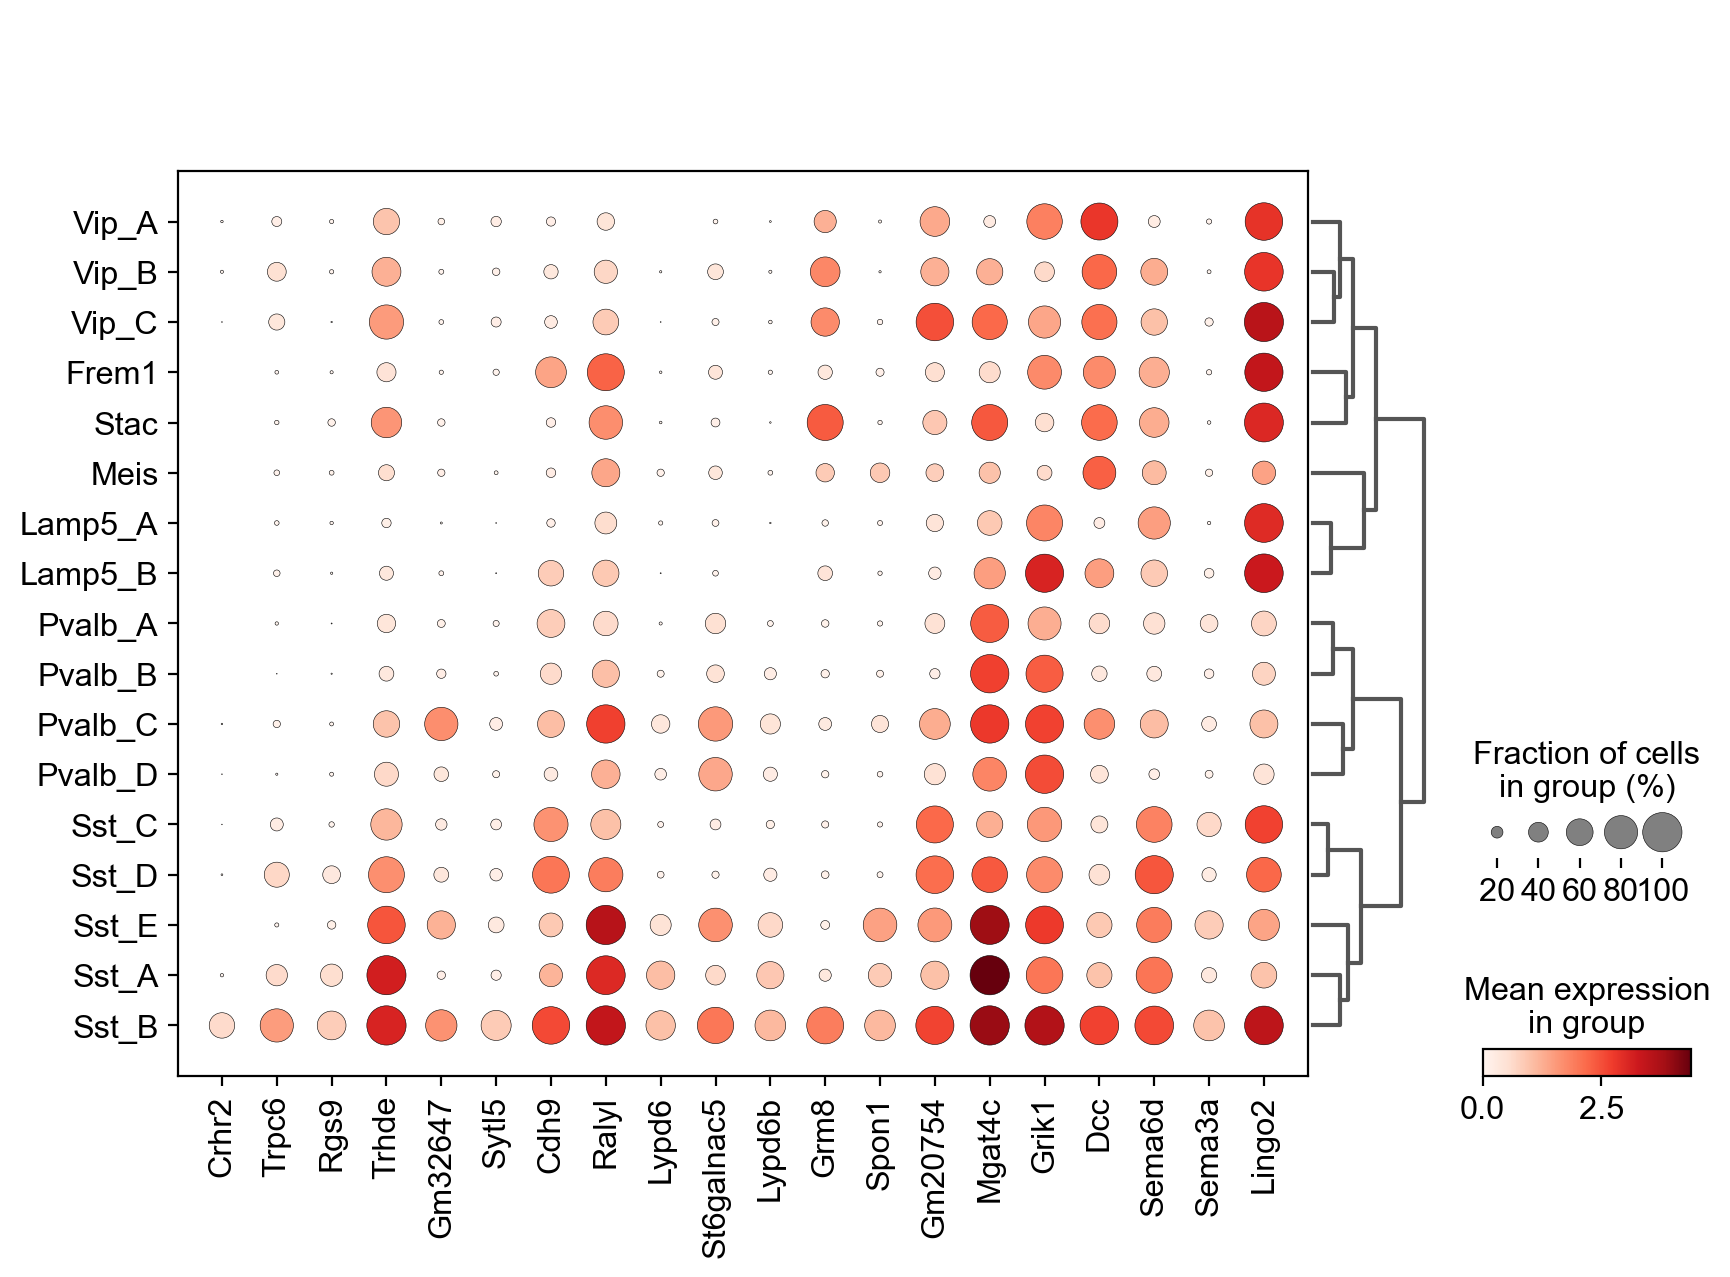

In [14]:
for i in P17_gaba.uns["dendrogram_['cluster_name']"]['categories_ordered']:
    cluster = i
    sc.tl.rank_genes_groups(P17_gaba, groupby='cluster_name', groups=[cluster], reference='rest', method='wilcoxon', n_genes=50)
    #wilcGenes23vRest = list(P17_gaba.uns['rank_genes_groups']['names'].astype([(cluster, '<U50')]).view('<U50'))  #list of genes ordered by wilc score
    #if ('Malat1' in wilcGenes23vRest): del wilcGenes23vRest[wilcGenes23vRest.index('Malat1')]

    wilcLF8v14 = P17_gaba.uns['rank_genes_groups']['logfoldchanges'].astype([(cluster, '<f8')]).view('<f8') #log fold changes ordered by score

    wilcGenes8v14_s = list(P17_gaba.uns['rank_genes_groups']['names'].astype([(cluster, '<U50')]).view('<U50'))  #list of genes ordered by wilc score
    wilcLF8v14_s = P17_gaba.uns['rank_genes_groups']['logfoldchanges'].astype([(cluster, '<f8')]).view('<f8') #numpy array of logfoldchnages to be ordered lowest to highest
    wilcLF8v14_s.sort() #log fold changes from lowest to highest
    wilcGenes8v14 = [] #list of genes ordered by logfold change: low to high
    for i in wilcLF8v14_s:
        gene_idx = np.where(wilcLF8v14 == i)[0][0]
        wilcGenes8v14.append(wilcGenes8v14_s[gene_idx])
    wilcGenes8v14_correct = []
    for i in reversed(wilcGenes8v14):
        wilcGenes8v14_correct.append(i) # #list of genes ordered by logfold change high to low

    sc.pl.dotplot(P17_gaba, wilcGenes8v14_correct[0:20], groupby='cluster_name', dendrogram=True)

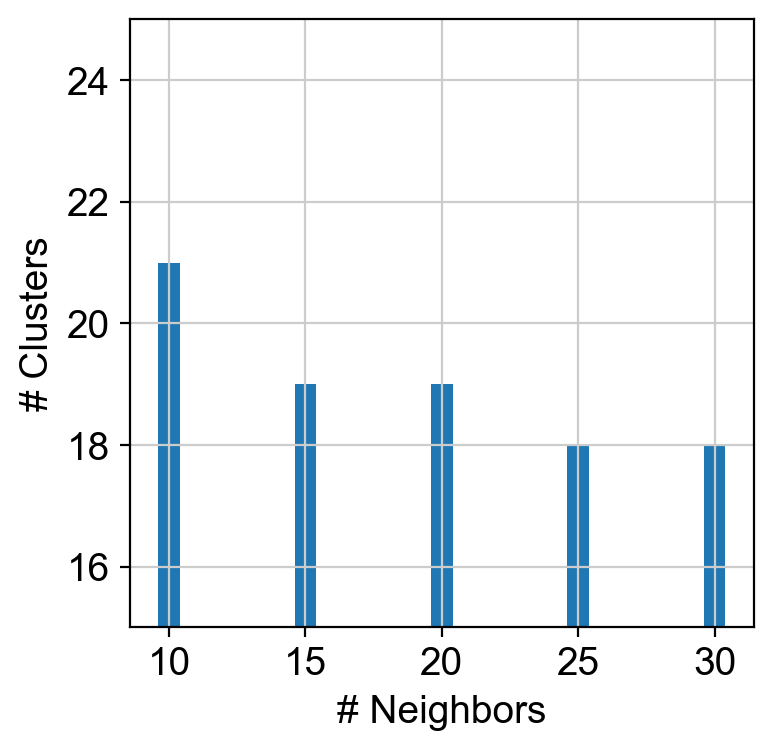

In [340]:
plt.bar([10, 15, 20, 25, 30], [21, 19, 19, 18, 18])
plt.xlabel('# Neighbors')
plt.ylabel('# Clusters')
plt.ylim(15, 25)
plt.show()

# Save

In [ ]:
P17_gaba.write_h5ad('/Volumes/GoogleDrive/.shortcut-targets-by-id/1QGxZoHVFYT0iH2PZKwk8j8Z_MzEI00IP/shekharlab_data/projects/MVC/h5ads_postFig1/gaba_h5ads/processed_Meis2/P17_gaba0828.h5ad')